<h1 align='center'> A Deep Learning Approach to Diabetes Diagnosis</h1>





# I. Import Libraries

In [1]:
# Data Analysis and Visualization
import numpy as np
import numba as nb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline


from scipy import stats

# # Import module for data visualization
# from plotnine import *
# import plotnine

import matplotlib.colors as mcolors

#---------------------------sklearn for SML-------------------------------------

# Update sklearn
!pip install -U scikit-learn

# Logistic Regression
from sklearn.linear_model import LogisticRegression  
from sklearn.linear_model import LogisticRegressionCV   # Logistic Regression with Cross Validation

# PCA
from sklearn.decomposition import PCA 

# t-SNE
from sklearn.manifold import TSNE

# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# KNN
from sklearn.neighbors import KNeighborsClassifier  

# SVM
from sklearn.svm import SVC

# Bagging
from sklearn.ensemble import BaggingClassifier

# encoding variables
from sklearn.preprocessing import LabelEncoder 

# Standard Scaler 
from sklearn.preprocessing import StandardScaler       

# data split
from sklearn.model_selection import train_test_split 

# Resample unbalanced data
from sklearn.utils import resample

# nominal variable
#from sklearn.preprocessing import OneHotEncoder

# metrics
from sklearn import metrics
# Validation scoring
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# ROC
from sklearn.metrics import roc_curve

# Precision-Recall curve
from sklearn.metrics import precision_recall_curve

# import sklearn metrics for validation
import sklearn.metrics as skm


# cross validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold 

# import cdist for SSE (Distortion)
from scipy.spatial.distance import cdist


# decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor      
from sklearn import tree    

# Random forest
from sklearn.ensemble import RandomForestClassifier

# KMeans Clustering
from sklearn.cluster import KMeans  


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

#---------------------------Self-Organizing Map---------------------------------

!pip install sklearn-som
from sklearn_som.som import SOM

# This is more flexible than som-learn:

# !pip install -U som-learn
# from somlearn import SOM 

#----------------------------PyTorch for DL---------------------------------

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as trans
import torch.nn.functional as F

from torch.utils.data import DataLoader

#-----------------------------Keras for DL----------------------------------

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# !pip install torchmetrics
# from torchmetrics import ConfusionMatrix # Confusion matrix for validation

from numpy import loadtxt
import tensorflow as tf
from tensorflow import keras

#-----------------------------Grid Search------------------------------------

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


#
from collections import Counter

# math
import math


# ------------------------- XGBoost ------------------------------------
!pip install xgboost
from xgboost import XGBClassifier


# --------------------------TorchViz---------------------------------------
!pip install torchviz
from torchviz import make_dot




ModuleNotFoundError: No module named 'seaborn'

# II. Data Pre-Processing

## (I) Data spliting and scaling

- **Spliting** dataframe for training, testing and validation
- **Scaling** the predictor to normalize the impact factor, since each predictor has a different degree of impact on the outcome
    - Here, we use `StandardScaler()` to achieve this, we can also use `heatmap` alternatively.

In [ ]:
def data_split(data):
    
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    
    train_x, test_x, train_y, test_y = train_test_split(X,y,test_size = 0.2, random_state=0)
    return train_x, test_x, train_y, test_y

def data_scaling(train_x, test_x):
    # Method StandardScaler()
    ss = StandardScaler()
    ss_model = ss.fit(train_x)
    train_x_scaled = ss_model.transform(train_x)
    test_x_scaled = ss_model.transform(test_x)
    return train_x_scaled, test_x_scaled


def data_scaling_plot(data):
    X = data.iloc[:,:-1].to_numpy()
    y = data.iloc[:,-1].to_numpy()
    # Method StandardScaler()
    ss = StandardScaler()
    ss_model = ss.fit(X)
    X_scaled = ss_model.transform(X)
    np_new = np.hstack((X_scaled, y.reshape(len(y),1)))
    column_headers = data.columns.values.tolist()
    df_new = pd.DataFrame(data = np_new, columns = column_headers)
    return df_new


## (II) Data balancing

### Check the number of each class

In [ ]:
def check_num(df):
  print("Class 0:", (df.iloc[:,-1] == 0).sum())
  print("Class 1:", (df.iloc[:,-1] == 1).sum())

### Oversample

Oversample will not be used since it will introduced bias

In [ ]:
def oversample(df):
  #create two different dataframe of majority and minority class 
  if ((df.iloc[:,-1] == 0).sum()) >= ((df.iloc[:,-1] == 1).sum()):
    df_majority = df[(df.iloc[:,-1] == 0)] 
    df_minority = df[(df.iloc[:,-1] == 1)]
    n_major = (df.iloc[:,-1] == 0).sum()
  else:
    df_majority = df[(df.iloc[:,-1] == 1)] 
    df_minority = df[(df.iloc[:,-1] == 0)]
    n_major = (df.iloc[:,-1] == 1).sum()    
  
  # oversample minority class
  df_minority_oversample = resample(df_minority, 
                                  replace=True,    # sample with replacement
                                  n_samples= n_major, # to match majority class
                                  random_state=42)  # reproducible results
  # Combine
  resample_df = pd.concat([df_minority_oversample, df_majority])

  # Shuffle
  resample_df = resample_df.sample(frac=1, random_state=0).reset_index(drop=True)

  return resample_df

### Undersample

In [ ]:
def undersample(df):
  #create two different dataframe of majority and minority class 
  if ((df.iloc[:,-1] == 0).sum()) >= ((df.iloc[:,-1] == 1).sum()):
    df_majority = df[(df.iloc[:,-1] == 0)] 
    df_minority = df[(df.iloc[:,-1] == 1)]
    n_minor = (df.iloc[:,-1] == 1).sum()
  else:
    df_majority = df[(df.iloc[:,-1] == 1)] 
    df_minority = df[(df.iloc[:,-1] == 0)]
    n_minor = (df.iloc[:,-1] == 0).sum()   
  
  # oversample minority class
  df_majority_undersample = resample(df_majority, 
                                  replace=True,    # sample with replacement
                                  n_samples= n_minor, # to match minority class
                                  random_state=42)  # reproducible results
  # Combine
  resample_df = pd.concat([df_majority_undersample, df_minority])

  # Shuffle
  resample_df = resample_df.sample(frac=1, random_state=1).reset_index(drop=True)

  return resample_df

## (III) Data visualization

### 2D: PCA & t-SNE

In [ ]:
def dim2(df, size, markersize):
  '''
  Parameters:
  size is the size of marker in the plot, default is 1.5,
  markersize is the size of marker in the legend, default is 10.

  '''


  x = df.iloc[:,:-1].to_numpy()
  y = df.iloc[:,-1].to_numpy()

  ss = StandardScaler()
  ss_model = ss.fit(x)
  x_scaled = ss_model.transform(x)

# ============ PCA ===============
  pca = PCA(n_components=2)

  x_pca = pca.fit_transform(x_scaled)

  np_pca = np.hstack((x_pca, y.reshape(len(y),1)))

  column_pca = ['pc_0', 'pc_1', 'class']

  df_pca = pd.DataFrame(data = np_pca, columns = column_pca)


  df_0_pca = df_pca[(df_pca.iloc[:,-1] == 0)]
  df_1_pca = df_pca[(df_pca.iloc[:,-1] == 1)]
  x_0_pca = df_0_pca.iloc[:,:-1].to_numpy()
  x_1_pca = df_1_pca.iloc[:,:-1].to_numpy()

# ============ t-SNE ===============

  tsne = TSNE(n_components=2)
  
  x_tsne = tsne.fit_transform(x_scaled)

  np_tsne = np.hstack((x_tsne, y.reshape(len(y),1)))

  column_tsne = ['dim_0', 'dim_1', 'class']

  df_tsne = pd.DataFrame(data = np_tsne, columns = column_tsne)


  df_0_tsne = df_tsne[(df_tsne.iloc[:,-1] == 0)]
  df_1_tsne = df_tsne[(df_tsne.iloc[:,-1] == 1)]
  x_0_tsne = df_0_tsne.iloc[:,:-1].to_numpy()
  x_1_tsne = df_1_tsne.iloc[:,:-1].to_numpy()


# ============ plot ===============

  fig = plt.figure(figsize = (16, 5))

  ax = plt.subplot(121)

  class_0_pca = ax.scatter(x_0_pca[:,0], x_0_pca[:,1], c='blue', s=size, alpha=0.3, label='Negative Cases')
  class_1_pca = ax.scatter(x_1_pca[:,0], x_1_pca[:,1], c='orange', s=size, alpha=0.3, label='Positive Cases')

  ax.legend(handles=[class_0_pca, class_1_pca] , markerscale=markersize, loc = 'best', 
            frameon = True, facecolor = 'white', edgecolor = 'black')
  plt.title('PCA', size = 12)
 
  ax2 = plt.subplot(122)

  class_0_tsne = ax2.scatter(x_0_tsne[:,0], x_0_tsne[:,1], c='blue', s=size, alpha=0.3, label='Negative Cases')
  class_1_tsne = ax2.scatter(x_1_tsne[:,0], x_1_tsne[:,1], c='orange', s=size, alpha=0.3, label='Positive Cases')

  ax2.legend(handles=[class_0_tsne, class_1_tsne] , markerscale=markersize, loc = 'best', 
            frameon = True, facecolor = 'white', edgecolor = 'black')
  plt.title('t-SNE', size = 12)


  plt.show()

### 2D: PCA only:

This served as a helper function for visualize the outcome of each classifier.

In [ ]:
def pca_plot(test_x_scaled, test_y, test_y_pred, size, markersize):

  pca = PCA(n_components=2)

  x_pca = pca.fit_transform(test_x_scaled)

  true_np = np.hstack((x_pca, test_y.reshape(len(test_y),1)))

  pred_np = np.hstack((x_pca, test_y_pred.reshape(len(test_y_pred),1)))

  column_true = ['pc_0', 'pc_1', 'true']

  column_pred = ['pc_0', 'pc_1', 'pred']

  true_df = pd.DataFrame(data = true_np, columns = column_true)

  pred_df = pd.DataFrame(data = pred_np, columns = column_pred)

  true_df_0 = true_df[(true_df.iloc[:,-1] == 0)]
  true_df_1 = true_df[(true_df.iloc[:,-1] == 1)]
  true_x_0 = true_df_0.iloc[:,:-1].to_numpy()
  true_x_1 = true_df_1.iloc[:,:-1].to_numpy()

  pred_df_0 = pred_df[(pred_df.iloc[:,-1] == 0)]
  pred_df_1 = pred_df[(pred_df.iloc[:,-1] == 1)]
  pred_x_0 = pred_df_0.iloc[:,:-1].to_numpy()
  pred_x_1 = pred_df_1.iloc[:,:-1].to_numpy()

  join_df = true_df.join(pred_df["pred"])

  correct_df = join_df[(join_df.true == join_df.pred)]

  wrong_df = join_df[(join_df.true != join_df.pred)]

  correct_df_0 = correct_df[(correct_df.iloc[:,-2] == 0)]
  correct_df_1 = correct_df[(correct_df.iloc[:,-2] == 1)]
  correct_x_0 = correct_df_0.iloc[:,:-2].to_numpy()
  correct_x_1 = correct_df_1.iloc[:,:-2].to_numpy()

  fn_df = wrong_df[(wrong_df.iloc[:,-1] == 0)]
  fp_df = wrong_df[(wrong_df.iloc[:,-1] == 1)]
  fn_x = fn_df.iloc[:,:-2].to_numpy()
  fp_x = fp_df.iloc[:,:-2].to_numpy()



# ============ plot ==================


  fig = plt.figure(figsize = (24, 5))

  ax1 = plt.subplot(131)


  true_class_0 = ax1.scatter(true_x_0[:,0], true_x_0[:,1], c='blue', s=size, alpha=0.3, label='Negative Cases')
  true_class_1 = ax1.scatter(true_x_1[:,0], true_x_1[:,1], c='orange', s=size, alpha=0.3, label='Positive Cases')

  ax1.legend(handles=[true_class_0, true_class_1] , markerscale=markersize, loc = 'best', 
            frameon = True, facecolor = 'white', edgecolor = 'black')
  plt.title('Ground Truth of Test Data', size = 12)

  ax2 = plt.subplot(132)


  pred_class_0 = ax2.scatter(pred_x_0[:,0], pred_x_0[:,1], c='blue', s=size, alpha=0.3, label='Negative Cases')
  pred_class_1 = ax2.scatter(pred_x_1[:,0], pred_x_1[:,1], c='orange', s=size, alpha=0.3, label='Positive Cases')

  ax2.legend(handles=[pred_class_0, pred_class_1] , markerscale=markersize, loc = 'best', 
            frameon = True, facecolor = 'white', edgecolor = 'black')
  plt.title('Prediction', size = 12)


  ax3 = plt.subplot(133)

  correct_class_0 = ax3.scatter(correct_x_0[:,0], correct_x_0[:,1], c='blue', s=size, alpha=0.3, label='True Negative')
  correct_class_1 = ax3.scatter(correct_x_1[:,0], correct_x_1[:,1], c='orange', s=size, alpha=0.3, label='True Positive')
  fn_class = ax3.scatter(fn_x[:,0], fn_x[:,1], c='green', s=size, alpha=0.3, label='False Negative')
  fp_class = ax3.scatter(fp_x[:,0], fp_x[:,1], c='red', s=size, alpha=0.3, label='False Positive')
  ax3.legend(handles=[correct_class_0, correct_class_1, fn_class, fp_class] , markerscale=markersize, loc = 'best', 
            frameon = True, facecolor = 'white', edgecolor = 'black')

  plt.title('Comparison', size = 12)











### 3D: PCA

In [ ]:
def dim3(df, size, markersize):
  x = df.iloc[:,:-1].to_numpy()
  y = df.iloc[:,-1].to_numpy()

  ss = StandardScaler()
  ss_model = ss.fit(x)
  x_scaled = ss_model.transform(x)

  pca_1 = PCA(n_components = 3).fit(x_scaled)

  Xt = pca_1.transform(x_scaled)

  new_np = np.hstack((Xt, y.reshape(len(y),1)))

  column_values = ['pc_0', 'pc_1', 'pc_2', 'class']

  new_df = pd.DataFrame(data = new_np, columns = column_values)


  df_0 = new_df[(new_df.iloc[:,-1] == 0)]
  df_1 = new_df[(new_df.iloc[:,-1] == 1)]
  x_0 = df_0.iloc[:,:-1].to_numpy()
  y_0 = df_0.iloc[:,-1].to_numpy()
  x_1 = df_1.iloc[:,:-1].to_numpy()
  y_1 = df_1.iloc[:,-1].to_numpy()

  
  fig = plt.figure(figsize = (16, 5))
  
  ax = plt.subplot(121, projection ="3d")
  class_0 = ax.scatter3D(x_0[:,0], x_0[:,1], x_0[:,2], c='blue', s=size, alpha=0.3, label='Negative Cases')
  class_1 = ax.scatter3D(x_1[:,0], x_1[:,1], x_1[:,2], c='orange', s=size, alpha=0.3, label='Positive Cases')
  ax.legend(handles=[class_0, class_1] , markerscale=markersize, loc = 'best', 
            frameon = True, facecolor = 'white', edgecolor = 'black')
  

  ax_2 = plt.subplot(122, projection ="3d")
  class_0_2 = ax_2.scatter3D(x_0[:,1], x_0[:,0], x_0[:,2], c='blue', s=size, alpha=0.3, label='Negative Cases')
  class_1_2 = ax_2.scatter3D(x_1[:,1], x_1[:,0], x_1[:,2], c='orange', s=size, alpha=0.3, label='Positive Cases')
  ax_2.legend(handles=[class_0, class_1] , markerscale=markersize, loc = 'best', 
            frameon = True, facecolor = 'white', edgecolor = 'black')

  plt.show()



# III. Statistical Learning Methods

## Supervised Learning:

## (I) LDA + K-Fold Cross Validation


In [ ]:
def lda(df, k, size, markersize):
  train_x, test_x, train_y, test_y = data_split(df)
  train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

  clf = LinearDiscriminantAnalysis()

  cv_result = cross_validate(clf, train_x_scaled, train_y, cv=5 ,scoring='accuracy',n_jobs=-1, return_train_score = True)
  train_score = np.mean(cv_result['train_score'])
  val_score = np.mean(cv_result['test_score'])

  clf.fit(train_x_scaled, train_y)

  test_y_pred = clf.predict(test_x_scaled)

  tn, fp, fn, tp = confusion_matrix(test_y, test_y_pred).ravel()

  print("Training Accuracy:", clf.score(train_x_scaled, train_y))
  print("CV Training Accuracy:", train_score)
  print("Validation Score", val_score)
  print("Testing Accuracy:", clf.score(test_x_scaled, test_y))
  print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

  # ============= plot ================

  pca_plot(test_x_scaled, test_y.to_numpy(), test_y_pred, size, markersize)


## (II) KNN + Optimal K + K-Fold Cross Validation

The reason why we choose KNN is that it is very efficient unless the input data is high-dimensional.

In [ ]:
def knn_cv(df,n,size, markersize):
    train_x, test_x, train_y, test_y = data_split(df)
    train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
    #-------------------------
    # find the optimal K
    # create a validation set
    
    
    best_k = -1
    best_score = -1
    for k in [1,2,3,5,7,9,15,31,51,train_x_scaled.shape[0]]:
        knn = KNeighborsClassifier(n_neighbors=k)    # just change the n_neighbors parameter
        
        cv_result = cross_validate(knn, train_x_scaled, train_y, cv=n ,scoring='accuracy',n_jobs=-1, return_train_score = True)
        train_score = np.mean(cv_result['train_score'])
        val_score = np.mean(cv_result['test_score'])
        
        knn_model = knn.fit(train_x_scaled, train_y) # scaled X, un-scaled y
        print("k:", k, "Training Score:", train_score, "Validation Score: ", val_score)
        # find the best k
        if best_score <= val_score:
            best_score = val_score
            best_model = knn_model
            best_k = k
    

    test_y_pred = best_model.predict(test_x_scaled)
    tn, fp, fn, tp = confusion_matrix(test_y, test_y_pred).ravel()
    print(f'The best k is {best_k} and the best val score is {best_score:.4f}')


    # Print the validation, training and testing scores for the best model  
    print("Training Score: {:.4f}".format(best_model.score(train_x_scaled, train_y)),
    "\n Test Score: {:.4f}".format(best_model.score(test_x_scaled, test_y)))
    print("Testing: Sensitivity:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

    # ============== plot =================

    pca_plot(test_x_scaled, test_y.to_numpy(), test_y_pred, size, markersize)



## (III) Logistic Regression + K-Fold Cross Validation

The reason why we choose Logistic Regression is that it's one of the most suitable classifier for binomial classification.

In [ ]:
def lg(df,k,size, markersize):
    train_x, test_x, train_y, test_y = data_split(df)
    train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

    mdl = LogisticRegressionCV(cv=k, multi_class='ovr', random_state=0).fit(train_x_scaled, train_y)
    
    test_y_pred = mdl.predict(test_x_scaled)
    tn, fp, fn, tp = confusion_matrix(test_y, test_y_pred).ravel()


    print("Training Accuracy:", mdl.score(train_x_scaled, train_y))
    print("Testing Accuracy:", mdl.score(test_x_scaled, test_y))
    print("Testing: Sensitivity:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

    # ============== plot =================

    pca_plot(test_x_scaled, test_y.to_numpy(), test_y_pred, size, markersize)


## (IV) SVM + K-Fold Cross Validation

In [ ]:
def svm(df,n,size, markersize):
  train_x, test_x, train_y, test_y = data_split(df)
  train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
  mdl = SVC(kernel='linear')
  
  cv_result = cross_validate(mdl, train_x_scaled, train_y, cv=n ,scoring='accuracy',n_jobs=-1, return_train_score = True)
  train_score = np.mean(cv_result['train_score'])
  val_score = np.mean(cv_result['test_score'])
  
  mdl.fit(train_x_scaled, train_y)

  test_y_pred = mdl.predict(test_x_scaled)

  tn, fp, fn, tp = confusion_matrix(test_y, test_y_pred).ravel()

  print("Training Accuracy:", mdl.score(train_x_scaled, train_y))
  print("CV Training Accuracy:", train_score)
  print("Validation Score", val_score)
  print("Testing Accuracy:", mdl.score(test_x_scaled, test_y))
  print("Testing: Sensitivity:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

  # ============== plot =================

  pca_plot(test_x_scaled, test_y.to_numpy(), test_y_pred, size, markersize)


## (V) Decision Trees + K-Fold Cross Validation

In [ ]:
def tree_cv(df, k, size, markersize):
  # Data Spliting
  train_x, test_x, train_y, test_y = data_split(df)
  train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


  # Create a hyperparameters_dict
  hyperparameters_dict = {'max_depth': range(2,20,2),
                    'min_samples_split': range(2, 20, 2), 
                    'min_samples_leaf': range(2, 20, 2) }

  # Grid Search with 5 cross fold validation
  best_score = -1
  best_parameter = {'max_depth': 0,
                    'min_samples_split': 0, 
                    'min_samples_leaf': 0 }

  for max_depth in hyperparameters_dict['max_depth']:
      for min_samples_split in hyperparameters_dict['min_samples_split']:
          for min_samples_leaf in hyperparameters_dict['min_samples_leaf']:
              dt = DecisionTreeClassifier(max_depth=max_depth, 
                                          min_samples_split=min_samples_split, 
                                          min_samples_leaf=min_samples_leaf)
              # 5 cross fold validation
              scores = cross_validate(dt, train_x_scaled, train_y, cv=k ,scoring='accuracy',n_jobs=-1)['test_score']
              mean_score = np.mean(scores)
              if mean_score > best_score:
                  best_parameter['max_depth'] = max_depth
                  best_parameter['min_samples_split'] = min_samples_split
                  best_parameter['min_samples_leaf'] = min_samples_leaf
                  best_score = mean_score
                  
  print(f'the best model parameter: {best_parameter} and the best mean accuracy: {best_score:.4f}')

  # Apply best hyperparameters (best model) to visualise the decision tree

  dt_best = DecisionTreeClassifier(**best_parameter)
  dt_best_model = dt_best.fit(train_x_scaled, train_y)

  test_y_pred = dt_best_model.predict(test_x_scaled)

  tn, fp, fn, tp = confusion_matrix(test_y, test_y_pred).ravel()

  print("Best Model Training Score:", dt_best_model.score(train_x_scaled, train_y))
  print("Best Model Testing Score: ", dt_best_model.score(test_x_scaled, test_y))
  print("Testing: Sensitivity:", tp/(tp+fn), "Specificity:", tn/(tn+fp))


  # ======================= plot ================================
  
  pca_plot(test_x_scaled, test_y.to_numpy(), test_y_pred, size, markersize)

  # ==================== export tree ===========================

  # plt.figure(figsize=(48,48))  # set plot size (denoted in inches)
  # tree.plot_tree(dt_best_model, feature_names = train_x.columns)
  # plt.rcParams['font.size'] = 18
  # plt.plot()
  # plt.savefig('tree.png',dpi=200)
  # plt.show()

## Ensemble Methods:
Bagging and Random forests are examples of ensemble methods, where predictions are based on an ensemble of many individual predictors, just like the wisdom of crowds.




## (VI) Random Forest + K-Fold Cross Validation

In [ ]:
def forest(df, k, size, markersize):
  train_x, test_x, train_y, test_y = data_split(df)
  train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

  forest_mdl = RandomForestClassifier(max_depth=2, random_state=0)

  cv_result = cross_validate(forest_mdl, train_x_scaled, train_y, cv=5 ,scoring='accuracy',n_jobs=-1, return_train_score = True)
  train_score = np.mean(cv_result['train_score'])
  val_score = np.mean(cv_result['test_score'])

  forest_mdl.fit(train_x_scaled, train_y)

  test_y_pred = forest_mdl.predict(test_x_scaled)

  tn, fp, fn, tp = confusion_matrix(test_y, test_y_pred).ravel()

  print("Training Accuracy:", forest_mdl.score(train_x_scaled, train_y))
  print("CV Training Accuracy:", train_score)
  print("Validation Score", val_score)
  print("Testing Accuracy:", forest_mdl.score(test_x_scaled, test_y))
  print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

  # ============= plot ================

  pca_plot(test_x_scaled, test_y.to_numpy(), test_y_pred, size, markersize)


## (VII) Bagging + K-Fold Cross Validation

In [ ]:
def bagging(df, k, size, markersize):
  train_x, test_x, train_y, test_y = data_split(df)
  train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

  bagging_mdl = BaggingClassifier(base_estimator=SVC(),n_estimators=10, random_state=0)

  cv_result = cross_validate(bagging_mdl, train_x_scaled, train_y, cv=5 ,scoring='accuracy',n_jobs=-1, return_train_score = True)
  train_score = np.mean(cv_result['train_score'])
  val_score = np.mean(cv_result['test_score'])

  bagging_mdl.fit(train_x_scaled, train_y)

  test_y_pred = bagging_mdl.predict(test_x_scaled)

  tn, fp, fn, tp = confusion_matrix(test_y, test_y_pred).ravel()

  print("Training Accuracy:", bagging_mdl.score(train_x_scaled, train_y))
  print("CV Training Accuracy:", train_score)
  print("Validation Score", val_score)
  print("Testing Accuracy:", bagging_mdl.score(test_x_scaled, test_y))
  print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

  # ============= plot ================

  pca_plot(test_x_scaled, test_y.to_numpy(), test_y_pred, size, markersize)


## (VIII) XGBoost + K-Fold Cross Validation

In [ ]:
def xgboost_cv(df, k, size, markersize):
  train_x, test_x, train_y, test_y = data_split(df)
  train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

  mdl = XGBClassifier()

  cv_result = cross_validate(mdl, train_x_scaled, train_y, cv=5 ,scoring='accuracy',n_jobs=-1, return_train_score = True)
  train_score = np.mean(cv_result['train_score'])
  val_score = np.mean(cv_result['test_score'])

  mdl.fit(train_x_scaled, train_y)

  test_y_pred = mdl.predict(test_x_scaled)

  tn, fp, fn, tp = confusion_matrix(test_y, test_y_pred).ravel()

  print("Training Accuracy:", mdl.score(train_x_scaled, train_y))
  print("CV Training Accuracy:", train_score)
  print("Validation Score", val_score)
  print("Testing Accuracy:", mdl.score(test_x_scaled, test_y))
  print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

  # ============= plot ================

  pca_plot(test_x_scaled, test_y.to_numpy(), test_y_pred, size, markersize)


## Unsupervised Learning:

## (IX) K-Means Clustering + Optimal Initial Centroids (Seeds) + K-Fold Cross Validation

In [ ]:
def kmclustering(df, k, size, markersize):
  train_x, test_x, train_y, test_y = data_split(df)
  train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

  # Select 10 different random sets of seeds, do a K-means clustering for each. Select the clustering with best tightness.
  # We measure the tightness via SSE (Inertia).
  tightness = []
  for i in range(10):
      kmeanModel2 = KMeans(n_clusters=2, random_state=i).fit(train_x_scaled, train_y) 
      # Remark: Since Kmeans is unsupervised learning, y will be ignored, not used, present here just for API consistency by convention.
      tightness.append(kmeanModel2.inertia_)
  kmeanModel3 = KMeans(n_clusters=2, init = "k-means++").fit(train_x_scaled, train_y)
  tightness.append(kmeanModel3.inertia_)
  print("Tightness via SSE (Inertia):", tightness)

  kmc_model = KMeans(n_clusters=2, init = "k-means++")

  cv_result = cross_validate(kmc_model, train_x_scaled, train_y, cv=5 ,scoring='accuracy',n_jobs=-1, return_train_score = True)
  train_score = np.mean(cv_result['train_score'])
  val_score = np.mean(cv_result['test_score'])

  kmc_model.fit(train_x_scaled, train_y)

  train_y_pred = kmc_model.predict(train_x_scaled)
  train_y_pred_inverted = 1 - train_y_pred

  test_y_pred = kmc_model.predict(test_x_scaled)
  test_y_pred_inverted = 1 - test_y_pred


  if accuracy_score(train_y, train_y_pred) >= accuracy_score(train_y, train_y_pred_inverted):
    new_train_y_pred = train_y_pred
  else:
    new_train_y_pred = train_y_pred_inverted
  
  if accuracy_score(test_y, test_y_pred) >= accuracy_score(test_y, test_y_pred_inverted):
    new_test_y_pred = test_y_pred
  else:
    new_test_y_pred = test_y_pred_inverted 


  tn, fp, fn, tp = confusion_matrix(test_y, new_test_y_pred).ravel()

  print("Training Accuracy:", accuracy_score(train_y, new_train_y_pred))
  print("CV Training Accuracy:", train_score)
  print("Validation Score", val_score)
  print("Testing Accuracy:", accuracy_score(test_y, new_test_y_pred))
  print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

  # ============= plot ================

  pca_plot(test_x_scaled, test_y.to_numpy(), new_test_y_pred, size, markersize)

# IV. Deep Learning Methods

## (I) Self-Organizing Map (SOM)

In [ ]:
def som_mdl(df, k, size, markersize):
  train_x, test_x, train_y, test_y = data_split(df)
  train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


  som_2 = SOM(m=2, n=1, dim=len(train_x_scaled[0]), random_state=0)

  som_2.fit(train_x_scaled)

  train_y_pred = som_2.predict(train_x_scaled)
  train_y_pred_inverted = 1 - train_y_pred

  test_y_pred = som_2.predict(test_x_scaled)
  test_y_pred_inverted = 1 - test_y_pred

  if accuracy_score(train_y, train_y_pred) >= accuracy_score(train_y, train_y_pred_inverted):
    new_train_y_pred = train_y_pred
  else:
    new_train_y_pred = train_y_pred_inverted
  
  if accuracy_score(test_y, test_y_pred) >= accuracy_score(test_y, test_y_pred_inverted):
    new_test_y_pred = test_y_pred
  else:
    new_test_y_pred = test_y_pred_inverted 
  
  tn, fp, fn, tp = confusion_matrix(test_y, new_test_y_pred).ravel()

  print("Training Accuracy:", accuracy_score(train_y, new_train_y_pred))
  print("Testing Accuracy:", accuracy_score(test_y, new_test_y_pred))
  print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

  # ============= plot ================

  pca_plot(test_x_scaled, test_y.to_numpy(), new_test_y_pred, size, markersize)


## (II) CNN: Residual Neural Network (ResNet)

- **ResNet-14**
- ResNet-18
- ResNet-34
- **ResNet-50**
- ResNet-101
- ResNet-152

ResNet-14 and ResNet-50 will be used mainly, as these are typical examples of the Basic Block and Bottleneck composition, respectively.


In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=False)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=False)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, input_channels=3):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.dropout = nn.Dropout2d(p=0.5,inplace=False)

        #print "block.expansion=",block.expansion
        self.fc = nn.LazyLinear(2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        #print "view: ",x.data.shape
        x = self.fc(x)

        return x


def resnet14(**kwargs):
    model = ResNet(BasicBlock, [1, 1, 1, 1], **kwargs)
    return model


def resnet18(**kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model


def resnet34(**kwargs):
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model


def resnet50(**kwargs):
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def resnet101(**kwargs):
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def resnet152(**kwargs):
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model


# V. Datasets

First we need to study the correlation between the predictors and outcomes. In order to find the appropriate dataset as the research object, the screening of multiple is indispensable.  





| Name    | Description    |
| :------------- | :------------- |
|NIDDK_Pima|It's a dataset of 768 females at least 21 years old of Pima Indian heritage responses to National Institute of Diabetes and Digestive and Kidney Diseases's survey.|
|CDC_BRFSS2015|It's a dataset of 253,680 survey responses to the CDC's BRFSS2015.|
|Sylhet|This dataset has been collected using direct questionnaires from 520 patients of Sylhet Diabetes Hospital in Sylhet, Bangladesh.|
|BIT_2019|This dataset was collected in 2019 by Neha Prerna Tigga and Dr. Shruti Garg of the Department of Computer Science and Engineering, BIT Mesra|




-----





-----
# 1 . NIDDK Pima Indians Diabetes Database

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

####  Attribute Information
| Column Name    | Expression    |
| :------------- | :------------- |
| Pregnancies | Number of times pregnant |
| Glucose | Plasma glucose concentration a 2 hours in an oral glucose tolerance test |
| BloodPressure | Diastolic blood pressure (mm Hg) |
| SkinThickness | Triceps skin fold thickness (mm) |
| Insulin | 2-Hour serum insulin (mu U/ml) |
| BMI | Body mass index (weight in kg/(height in m)^2) |
| DiabetesPedigreeFunction | Diabetes pedigree function |
| Age | Age (years) |
| Outcome | Class variable (0 or 1) |





## 1.0 Data Pre-Processing

### 1.0.1 Loading data

In [ ]:
# Read 'NIDDK_Pima.csv'
niddk_df = pd.read_csv("./data/NIDDK_Pima.csv")

# Drop NaN value
print("Any null value:", any(niddk_df.isnull()))
print("Any NaN value:", any(niddk_df.isna()))
print("Before Droping NaN Number of Rows:", len(niddk_df))

niddk_df = niddk_df.dropna()
print("After Droping NaN Number of Rows:", len(niddk_df))

niddk_df.tail()

In [ ]:
corrMatrix = niddk_df.corr()

# Generate a heatmap
plt.figure(figsize=[24,16])
with sns.plotting_context("notebook",font_scale=2):
  sns.heatmap(corrMatrix, cmap="YlGnBu", annot=True)

---
### 1.0.2 Data Balance

In [ ]:
check_num(niddk_df)

Undersample

In [ ]:
niddk_df = undersample(niddk_df)
check_num(niddk_df)

In [ ]:
plt.figure(figsize = (8.4, 4.2))

plt.subplot(1, 2, 1)
x = ["Negative", "Positive"]
h = [500,268]
c = ['blue', 'orange']
bars = plt.bar(x, height = h, color = c)
plt.bar_label(bars)
plt.xlabel("Class", size=14)
plt.ylabel("Number of data", size=14)
plt.title("Unbalanced Data", size=14, fontweight='bold')


plt.subplot(1, 2, 2)
x = ["Negative", "Positive"]
h = [268,268]
c = ['blue', 'orange']
bars = plt.bar(x, height = h, color = c)
plt.bar_label(bars)
plt.ylim(0, 520)
plt.xlabel("Class", size=14)
plt.ylabel("Number of data", size=14)
plt.title("Balanced Data", size=14, fontweight='bold')


plt.show()

### 1.0.3 Data Scaling

Before Scaling

In [ ]:
plt.figure(figsize=[18,8])
with sns.plotting_context("notebook",font_scale=1.5):
  niddk_df.boxplot(column=niddk_df.columns.values.tolist()[:-1])
  plt.title("The distribution of features before scaling")

After scaling

In [ ]:
plt.figure(figsize=[18,8])
with sns.plotting_context("notebook",font_scale=1.5):
  data_scaling_plot(niddk_df).boxplot(column=niddk_df.columns.values.tolist()[:-1])
  plt.title("The distribution of features after scaling")

### 1.0.4 Data Visualization


#### 1.0.4.1 Visualization in 2D

In [ ]:
dim2(niddk_df, 100, 1)

-----

##  1.1 LDA + 5-Fold Cross Validation



In [ ]:
lda(niddk_df, 5, 100, 1)

##  1.2 KNN + Optimal K + 5-Fold Cross Validation



In [ ]:
knn_cv(niddk_df, 5, 100, 1)

-----

##  1.3 Logistic Regression + 5-Fold Cross Validation

In [ ]:
lg(niddk_df,5, 100, 1)

-----

##  1.4 SVM + 5-Fold Cross Validation

In [ ]:
svm(niddk_df,5, 100, 1)

## 1.5 Decision Trees + 5-Fold Cross Validation

In [ ]:
tree_cv(niddk_df,5, 100, 1)

## 1.6 Random Forest + 5-Fold Cross Validation


In [ ]:
forest(niddk_df,5, 100, 1)

## 1.7 Bagging + 5-Fold Cross Validation

In [ ]:
bagging(niddk_df,5, 100, 1)

## 1.8 XGBoost + 5-Fold Cross Validation

In [ ]:
xgboost_cv(niddk_df,5, 100, 1)

## 1.9 K-Means Clustering + Optimal Initial Centroids (Seeds) + 5-Fold Cross Validation

In [ ]:
kmclustering(niddk_df,5, 100, 1)

## 1.10 Self-Organizing Map (SOM)

In [ ]:
som_mdl(niddk_df,5, 100, 1)

## 1.11 ResNet

### 1.11.1 ResNet-14

Check if GPU is valid

In [ ]:
#!nvidia-smi

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(niddk_df)

train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

train_x_scaled_reshape = train_x_scaled.reshape(len(train_x_scaled),2,2,2)

test_x_scaled_reshape = test_x_scaled.reshape(len(test_x_scaled),2,2,2)


train_x_torch = torch.from_numpy(train_x_scaled_reshape).float()

test_x_torch = torch.from_numpy(test_x_scaled_reshape).float()


train_y_torch = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_y_torch = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())


modl = resnet14(num_classes=2, input_channels=2).to(device)

epochs = 300
batch = 128
lrate = 0.001

criterion = nn.CrossEntropyLoss().to(device)

optim = torch.optim.Adam(modl.parameters(), lr=lrate)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y_torch.shape[0]))
  source = train_x_torch[shuffle_indices]
  target = train_y_torch[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch].to(device)
    target_batch = target[start_i:start_i + batch]
    train_pred = torch.squeeze(modl(source_batch))
    losses = criterion(train_pred, target_batch.type(torch.LongTensor).to(device))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  train_pred_np = torch.argmax(train_pred, axis=1).cpu().numpy()
  train_acc = accuracy_score(target_batch, train_pred_np)

  test_pred = torch.squeeze(modl(test_x_torch.to(device)))

  test_loss = criterion(test_pred, test_y_torch.type(torch.LongTensor).to(device))

  test_pred_np = torch.argmax(test_pred, axis=1).cpu().numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

  if (epoch+1) % 1 == 0:

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)


  if (epoch+1) % 50 == 0:

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

# =========== plot ===========
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.plot(epoch_list, train_loss_list, label = "training loss", c = "blue")
plt.plot(epoch_list, test_loss_list, label = "testing loss", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')

plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Loss', size = 12)

plt.subplot(122)
plt.plot(epoch_list, train_acc_list, label = "training accuracy", c = "blue")
plt.plot(epoch_list, test_acc_list, label = "testing accuracy", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('accuracy')
plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Accuracy', size = 12)

plt.show()

pca_plot(test_x_scaled, test_y.to_numpy(), test_pred_np, 100, 1)


### 1.11.2 ResNet-50

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(niddk_df)

train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

train_x_scaled_reshape = train_x_scaled.reshape(len(train_x_scaled),2,2,2)

test_x_scaled_reshape = test_x_scaled.reshape(len(test_x_scaled),2,2,2)


train_x_torch = torch.from_numpy(train_x_scaled_reshape).float()

test_x_torch = torch.from_numpy(test_x_scaled_reshape).float()


train_y_torch = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_y_torch = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())


modl = resnet50(num_classes=2, input_channels=2).to(device)

epochs = 300
batch = 64
lrate = 0.001

criterion = nn.CrossEntropyLoss().to(device)

optim = torch.optim.Adam(modl.parameters(), lr=lrate)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y_torch.shape[0]))
  source = train_x_torch[shuffle_indices]
  target = train_y_torch[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch].to(device)
    target_batch = target[start_i:start_i + batch]
    train_pred = torch.squeeze(modl(source_batch))
    losses = criterion(train_pred, target_batch.type(torch.LongTensor).to(device))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  train_pred_np = torch.argmax(train_pred, axis=1).cpu().numpy()
  train_acc = accuracy_score(target_batch, train_pred_np)

  test_pred = torch.squeeze(modl(test_x_torch.to(device)))

  test_loss = criterion(test_pred, test_y_torch.type(torch.LongTensor).to(device))

  test_pred_np = torch.argmax(test_pred, axis=1).cpu().numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

  if (epoch+1) % 1 == 0:

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)


  if (epoch+1) % 50 == 0:

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

# =========== plot ===========
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.plot(epoch_list, train_loss_list, label = "training loss", c = "blue")
plt.plot(epoch_list, test_loss_list, label = "testing loss", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')

plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Loss', size = 12)

plt.subplot(122)
plt.plot(epoch_list, train_acc_list, label = "training accuracy", c = "blue")
plt.plot(epoch_list, test_acc_list, label = "testing accuracy", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('accuracy')
plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Accuracy', size = 12)

plt.show()

pca_plot(test_x_scaled, test_y.to_numpy(), test_pred_np, 100, 1)


## 1.12 BPNN



### 1.12.1 Parameter Tuning via Grid Search


We have following hyperparameters to be determined:

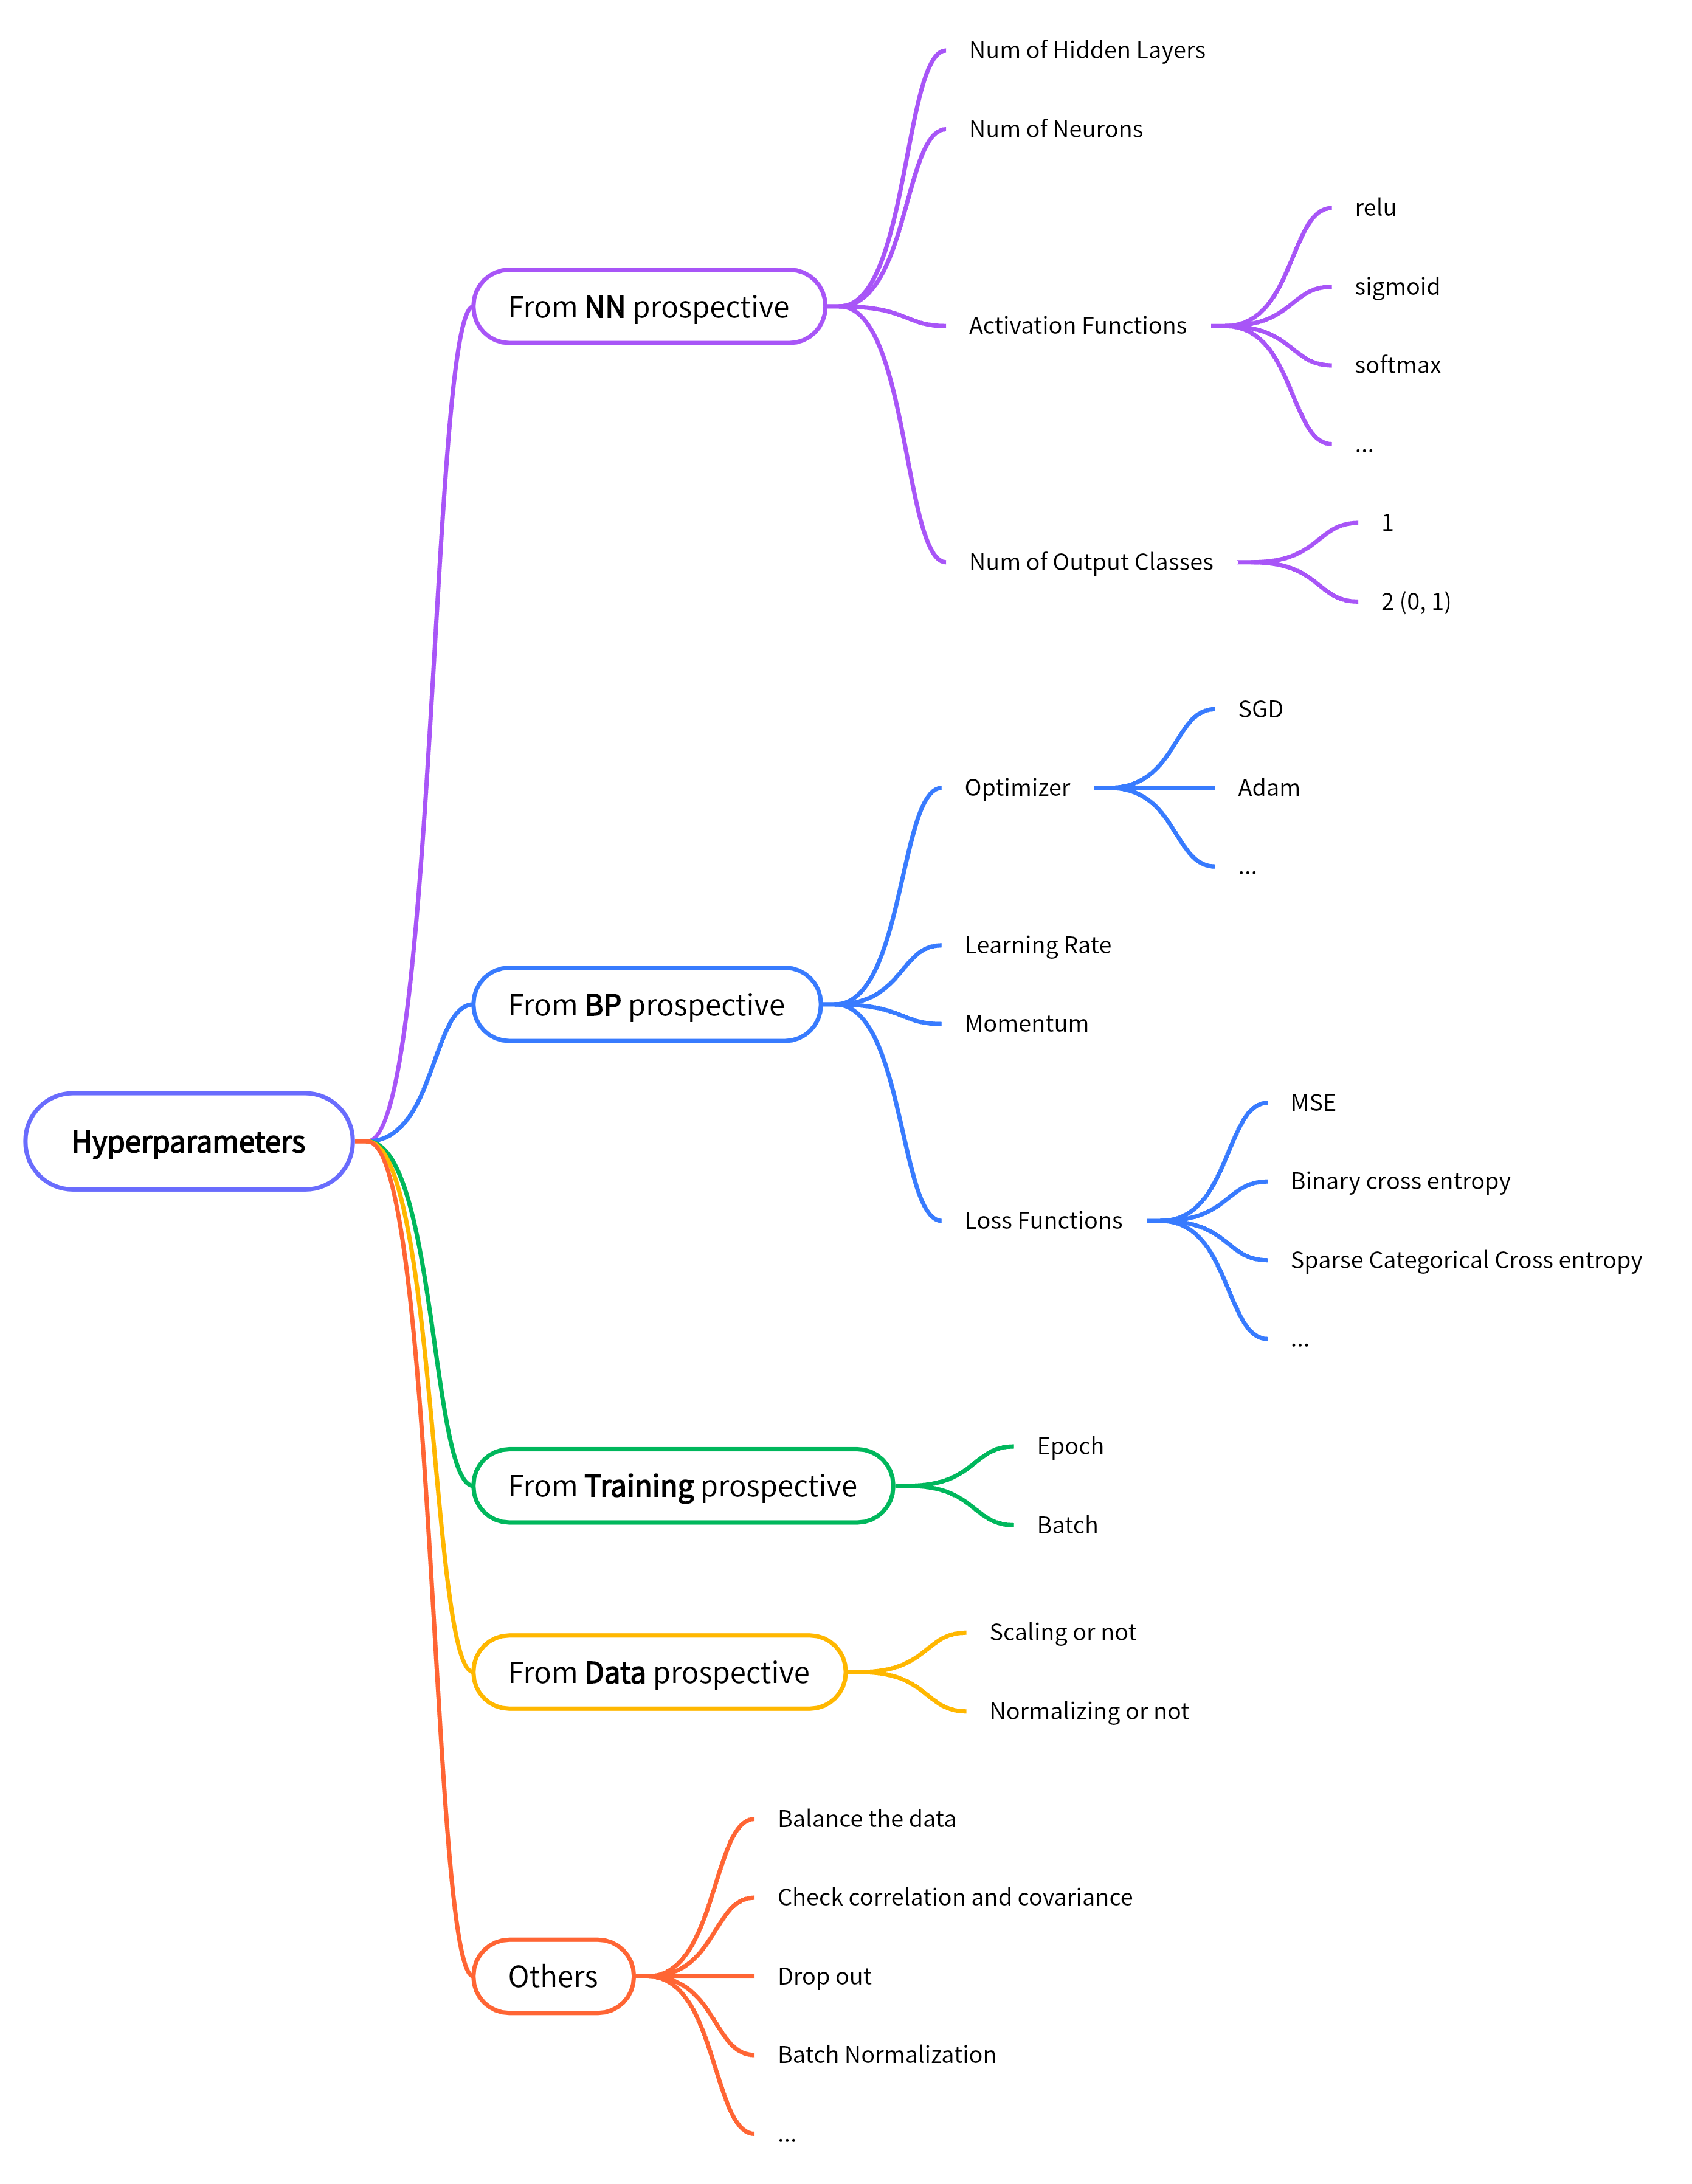

**1. Principles for determining the number of hidden layers** 

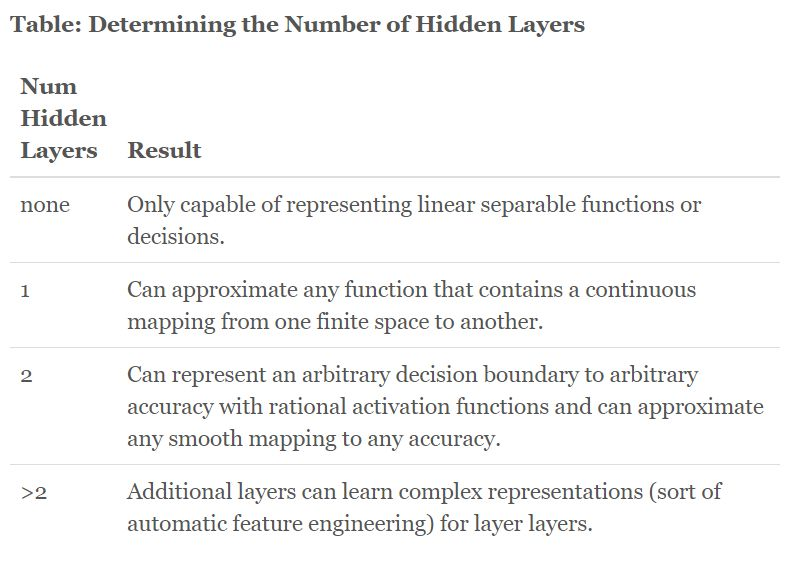

**2. Principles for determining the number of neurons of hidden layers** 

We have following empirical formulas:

1. $\text{Hidden Neurons}$ $=$ $\frac{\text{Num of Training Data}}{(2 \text{~} 10) {\kern 3pt}*{\kern 3pt} \text{(Input Neurons + Output Neurons)}}$

2. $\text{Hidden Neurons}$ $=$ $\sqrt{\text{Input Neurons * Output Neurons}}$

3. 
  - The number of hidden neurons should be between the size of the input layer and the size of the output layer.
  - The number of hidden neurons should be 2/3 of the size of the input layer plus 2/3 of the size of the output layer.
  - The number of hidden neurons should be less than twice the size of the input layer.


In [ ]:
# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(niddk_df)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

train_x_scaled = np.float32(train_x_scaled)
test_x_scaled = np.float32(test_x_scaled)

# ------- Normalize the predictors or not ----------
# train_x = train_x/train_x.max()
# test_x = test_x/test_x.max()
# --------------------------------------------------------

def gridNN(layers, activation, optimizer):
  mdl = Sequential()
  for i, neuron in enumerate(layers):
    mdl.add(Dense(neuron, activation = activation))
  mdl.add(Dense(1, activation='sigmoid'))
  mdl.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
  return mdl


mdl = KerasClassifier(build_fn = gridNN)

# Define Hyperparameters

layers = [[16,8,4],[32,16,8],[64,32,16]]
activations = ['sigmoid', 'relu', 'softmax']
optimizer = ['SGD', 'Adam']
batch = [8, 16, 32]
epoch = [1000]

para_grid = dict(layers=layers, activation=activations, optimizer=optimizer, batch_size=batch, epochs=epoch)

grid = GridSearchCV(estimator = mdl, param_grid = para_grid).fit(train_x_scaled,train_y)

df_gridsearch = pd.DataFrame(grid.cv_results_)

print("Training acc:", grid.best_score_, grid.best_params_)



#### BPNN Visualization via TorchViz

In [ ]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(niddk_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, hid3, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.batch_norm3 = nn.BatchNorm1d(num_features=hid3)
    self.fc4 = nn.Linear(hid3, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.batch_norm3(x)
    x = F.sigmoid(self.fc4(x))
    return x

input = train_x.shape[1] 
hid1 = 64
hid2 = 32
hid3 = 16
numclass = 2
epochs = 10000
batch = 16
lrate =0.001

modl = bpnn(input, hid1, hid2 ,hid3, numclass)

x = train_x
y = modl(x)

#make_dot(y.mean(), params=dict(modl.named_parameters()), show_attrs=True, show_saved=True).render("bpnn_torchviz", format="pdf")
make_dot(y.mean(), params=dict(modl.named_parameters()), show_attrs=True, show_saved=True)


In [ ]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(niddk_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, hid3, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.batch_norm3 = nn.BatchNorm1d(num_features=hid3)
    self.fc4 = nn.Linear(hid3, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.batch_norm3(x)
    x = F.sigmoid(self.fc4(x))
    return x

input = train_x.shape[1] 
hid1 = 64
hid2 = 32
hid3 = 16
numclass = 2
epochs = 10000
batch = 16
lrate =0.001

modl = bpnn(input, hid1, hid2 ,hid3, numclass)

x = train_x
y = modl(x)

#make_dot(y.mean(), params=dict(modl.named_parameters())).render("bpnn_torchviz", format="pdf")
make_dot(y.mean(), params=dict(modl.named_parameters()))


### 1.12.2 BPNN + Batch Normalization

In [ ]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(niddk_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, hid3, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.batch_norm3 = nn.BatchNorm1d(num_features=hid3)
    self.fc4 = nn.Linear(hid3, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.batch_norm3(x)
    x = F.sigmoid(self.fc4(x))
    return x

input = train_x.shape[1] 
hid1 = 64
hid2 = 32
hid3 = 16
numclass = 2
epochs = 10000
batch = 16
lrate =0.001

modl = bpnn(input, hid1, hid2 ,hid3, numclass)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optim = torch.optim.Adam(modl.parameters(), lr=lrate)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch.type(torch.LongTensor))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  train_pred_np = torch.argmax(train_pred, axis=1).numpy()
  train_acc = accuracy_score(target_batch, train_pred_np)

  test_pred = modl(test_x)
  test_pred = torch.squeeze(test_pred)

  test_loss = criterion(test_pred, test_y.type(torch.LongTensor))

  test_pred_np = torch.argmax(test_pred, axis=1).numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

  if (epoch+1) % 50 == 0:

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)

  if test_acc >= 0.89:
    print("=================================================")
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))
    break


  if (epoch+1) % 100 == 0:

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))



# =========== plot ===========
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.plot(epoch_list, train_loss_list, label = "training loss", c = "blue")
plt.plot(epoch_list, test_loss_list, label = "testing loss", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')

plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Loss', size = 12)

plt.subplot(122)
plt.plot(epoch_list, train_acc_list, label = "training accuracy", c = "blue")
plt.plot(epoch_list, test_acc_list, label = "testing accuracy", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')
plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Accuracy', size = 12)

plt.show()

pca_plot(test_x_scaled, test_y, test_pred_np, 100, 1)



## Outcome Comparsion

**Hence, we have the outcome comparsion**

| Classifier    | Training Acc    | Testing Acc|Sensitivity|Specificity|
| :------------- | :------------- | :------------- | :------------- | :------------- |
| LDA | 0.7453 |  0.7222|  0.6721 |  0.7872
| KNN | 1.000 | 0.8148 |0.7705| 0.8723
| Logistic Regression | 0.7313 | 0.6852 | 0.6230 | 0.7660
| SVM| 0.7383 | 0.7130 | 0.6393 | 0.8085
| Decision Trees| 0.8832 | 0.7037 | 0.6885 | 0.7234
| Random Forest| 0.7944 | 0.7222 | 0.7213 | 0.7234
| Bagging| 0.8154 | 0.6944 | 0.6230| 0.7872
| XGBoost| 0.9346 | 0.7870 |  0.7377 | 0.8511
| K-Means Clustering| 0.6706 | 0.6481 |0.4590 |0.8936
| Self-Organizing Map (SOM)| 0.7266 | 0.7130 |0.6721|0.7660
| ResNet-14| 0.9922 |0.7963 |0.7049 | 0.9149
| ResNet-50| 1.0 | 0.7870|0.7706|0.8085
| **BPNN + Batch Norm (this study)**|**0.9375**|**0.8981**|**0.8929**|**0.9038**


In [ ]:
with sns.plotting_context("notebook",font_scale=1.5):

    plt.figure(figsize = (28, 5))
    x = ["LDA", "KNN", "LR", "SVM", "DT", "RF","Bagging","XGBoost", "KMeans", "SOM", "RN14", "RN50", "CkNN", "GDA-LSSVM", "GA-MLP", "GRNN", "MLFNN","BPNN"]
    h = [0.7222,
    0.8148,
    0.6852,
    0.7130,
    0.7037,
    0.7222,
    0.6944,
    0.7870,
    0.6481,
    0.7130,
    0.7963,
    0.7870,
    0.7816,
    0.7916,
    0.8040,
    0.8021,
    0.8173,
    0.8981]
    bars = plt.bar(x, height = h, color = mcolors.TABLEAU_COLORS)
    plt.bar_label(bars)
    plt.xlabel("Classifier", size=14)
    plt.ylabel("Accuracy", size=14)
    plt.title("Accuracy Comparison on NIDDK Pima Dataset", size=14, fontweight='bold')

    ticklabels = [t for t in plt.gca().get_xticklabels()]

    ticklabels[-1].set_fontweight("bold")
    ticklabels[-1].set_color("red")

    barlabels = [t for t in plt.bar_label(bars)]

    barlabels[-1].set_fontweight("bold")
    barlabels[-1].set_color("red")
    plt.ylim(0, 1)

    plt.show()

# 2 . CDC BRFSS2015 Database

This is a clean dataset of 253,680 survey responses to the CDC's BRFSS2015 with 22 features. These features are either questions directly asked of participants, or calculated variables based on individual participant responses.

####  Attribute Information
| Column Name    | Expression    |
| :------------- | :------------- |
| Diabetes_binary| 0 = no diabetes 1 = diabetes |
| HighBP      | 0 = no high BP 1 = high BP |
| HighChol    | 0 = no high cholesterol 1 = high cholesterol |
| CholCheck       | 0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years |
| BMI            | Body Mass Index |
| Smoker      | Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes |
| Stroke       | (Ever told) you had a stroke. 0 = no 1 = yes |
| HeartDiseaseorAttack        | coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes |
| PhysActivity       | physical activity in past 30 days - not including job 0 = no 1 = yes |
| Fruits        | Consume Fruit 1 or more times per day 0 = no 1 = yes |
| Veggies        | Consume Vegetables 1 or more times per day 0 = no 1 = yes |
| HvyAlcoholConsump        | (adult men >=14 drinks per week and adult women>=7 drinks per week) 0 = no 1 = yes |
| AnyHealthcare        | Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes |
| NoDocbcCost        | Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes |
| GenHlth       | Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor |
| MentHlth        | days of poor mental health scale 1-30 days |
| PhysHlth        | physical illness or injury days in past 30 days scale 1-30 |
| DiffWalk        | Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes |
| Sex        | 0 = female 1 = male |
| Age        | 13-level age category 1 = 18-24 9 = 60-64 13 = 80 or older |
| Education        | Education level scale 1-6 1 = Never attended school or only kindergarten 2 = elementary etc. |
| Income        | Income scale 1-8 1 = less than `$10000`, 5 = less than `$35000`, 8 = `$75000` or more |


## 2.0 Data Pre-Processing

### 2.0.1 Loading data

In [ ]:
# Read 'CDC_BRFSS2015.csv'
cdc_df = pd.read_csv("./data/CDC_BRFSS2015.csv")

# Drop NaN value
print("Any null value:", any(cdc_df.isnull()))
print("Any NaN value:", any(cdc_df.isna()))
print("Before Droping NaN Number of Rows:", len(cdc_df))

cdc_df = cdc_df.dropna()
print("After Droping NaN Number of Rows:", len(cdc_df))

# Move 'Diabetes_binary' column to the end of dataframe
cdc_df['Diabetes_binary'] = cdc_df.pop('Diabetes_binary')

cdc_df.tail()



---
### 2.0.2 Data Balance

In [ ]:
check_num(cdc_df)

Undersample

In [ ]:
cdc_df = undersample(cdc_df)

check_num(cdc_df)

### 2.0.3 Other

In [ ]:
# Correlation contingency table
cdc_corr = cdc_df.corr()
cdc_corr

In [ ]:
print(cdc_corr.iloc[-1,:].sort_values(ascending=False))

Moreover, we evaluate the Weighted Average of the correlation of predictors:

$\text{Weighted Average of Correlation}$ $=$ $\frac{\text{Sum of Correlation of Predictors}}{\text{Number of Predictors}}$ $=$ $0.098
$


In [ ]:
# Evaluate the Weighted Average of the correlation of predictors

print("Weighted Average:", sum(cdc_corr.iloc[-1,:-1])/21)

### 2.0.4 Data Visualization


#### 2.0.4.1 Visualization in 2D

In [ ]:
dim2(cdc_df)

#### 2.0.4.2 Visualization in 3D

In [ ]:
dim3(cdc_df)

-----

##  2.1 LDA + 5-Fold Cross Validation



In [ ]:
lda(cdc_df, 5, 3, 10)

-----

##  2.2 KNN + Optimal K + 5-Fold Cross Validation



In [ ]:
knn_cv(cdc_df, 5, 3, 10)

##  2.3 Logistic Regression + 5-Fold Cross Validation

In [ ]:
lg(cdc_df,5, 3, 10)

##  2.4 SVM + 5-Fold Cross Validation

In [ ]:
svm(cdc_df,5, 3, 10)

## 2.5 Decision Trees + 5-Fold Cross Validation

In [ ]:
tree_cv(cdc_df,5, 3, 10)

## 2.6 Random Forest + 5-Fold Cross Validation


In [ ]:
forest(cdc_df,5, 3, 10)

## 2.7 Bagging + 5-Fold Cross Validation

In [ ]:
bagging(cdc_df,5, 3, 10)

## 2.8 XGBoost + 5-Fold Cross Validation

In [ ]:
xgboost_cv(cdc_df,5, 3, 10)

## 2.9 K-Means Clustering + Optimal Initial Centroids (Seeds) + 5-Fold Cross Validation

In [ ]:
kmclustering(cdc_df,5, 3, 10)

## 2.10 Self-Organizing Map (SOM)

In [ ]:
som_mdl(cdc_df,5, 3, 10)

## 2.11 ResNet

### 2.11.1 ResNet-14

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(cdc_df)

train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

train_x_scaled_reshape = train_x_scaled.reshape(len(train_x_scaled),7,3,1)

test_x_scaled_reshape = test_x_scaled.reshape(len(test_x_scaled),7,3,1)


train_x_torch = torch.from_numpy(train_x_scaled_reshape).float()

test_x_torch = torch.from_numpy(test_x_scaled_reshape).float()


train_y_torch = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_y_torch = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())


modl = resnet14(num_classes=2, input_channels=7).to(device)

epochs = 30
batch = 64
lrate = 0.001

criterion = nn.CrossEntropyLoss().to(device)

optim = torch.optim.Adam(modl.parameters(), lr=lrate)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y_torch.shape[0]))
  source = train_x_torch[shuffle_indices]
  target = train_y_torch[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch].to(device)
    target_batch = target[start_i:start_i + batch]
    train_pred = torch.squeeze(modl(source_batch))
    losses = criterion(train_pred, target_batch.type(torch.LongTensor).to(device))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  train_pred_np = torch.argmax(train_pred, axis=1).cpu().numpy()
  train_acc = accuracy_score(target_batch, train_pred_np)

  test_pred = torch.squeeze(modl(test_x_torch.to(device)))

  test_loss = criterion(test_pred, test_y_torch.type(torch.LongTensor).to(device))

  test_pred_np = torch.argmax(test_pred, axis=1).cpu().numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

  if (epoch+1) % 1 == 0:

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)


  if (epoch+1) % 3 == 0:

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

# =========== plot ===========
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.plot(epoch_list, train_loss_list, label = "training loss", c = "blue")
plt.plot(epoch_list, test_loss_list, label = "testing loss", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')

plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Loss', size = 12)

plt.subplot(122)
plt.plot(epoch_list, train_acc_list, label = "training accuracy", c = "blue")
plt.plot(epoch_list, test_acc_list, label = "testing accuracy", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('accuracy')
plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Accuracy', size = 12)

plt.show()

pca_plot(test_x_scaled, test_y.to_numpy(), test_pred_np, 1.5, 10)


### 2.11.2 ResNet-50

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(cdc_df)

train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

train_x_scaled_reshape = train_x_scaled.reshape(len(train_x_scaled),7,3,1)

test_x_scaled_reshape = test_x_scaled.reshape(len(test_x_scaled),7,3,1)


train_x_torch = torch.from_numpy(train_x_scaled_reshape).float()

test_x_torch = torch.from_numpy(test_x_scaled_reshape).float()


train_y_torch = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_y_torch = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())


modl = resnet50(num_classes=2, input_channels=7).to(device)

epochs = 30
batch = 512
lrate = 0.001

criterion = nn.CrossEntropyLoss().to(device)

optim = torch.optim.Adam(modl.parameters(), lr=lrate)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y_torch.shape[0]))
  source = train_x_torch[shuffle_indices]
  target = train_y_torch[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch].to(device)
    target_batch = target[start_i:start_i + batch]
    train_pred = torch.squeeze(modl(source_batch))
    losses = criterion(train_pred, target_batch.type(torch.LongTensor).to(device))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  train_pred_np = torch.argmax(train_pred, axis=1).cpu().numpy()
  train_acc = accuracy_score(target_batch, train_pred_np)

  test_pred = torch.squeeze(modl(test_x_torch.to(device)))

  test_loss = criterion(test_pred, test_y_torch.type(torch.LongTensor).to(device))

  test_pred_np = torch.argmax(test_pred, axis=1).cpu().numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

  if (epoch+1) % 1 == 0:

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)


  if (epoch+1) % 6 == 0:

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

# =========== plot ===========
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.plot(epoch_list, train_loss_list, label = "training loss", c = "blue")
plt.plot(epoch_list, test_loss_list, label = "testing loss", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')

plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Loss', size = 12)

plt.subplot(122)
plt.plot(epoch_list, train_acc_list, label = "training accuracy", c = "blue")
plt.plot(epoch_list, test_acc_list, label = "testing accuracy", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('accuracy')
plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Accuracy', size = 12)

plt.show()

pca_plot(test_x_scaled, test_y.to_numpy(), test_pred_np, 1.5, 10)


## 2.12 BPNN

-----

### 2.12.1 Parameter Tuning via Grid Search

In [ ]:
# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(cdc_df)

train_x = np.float32(train_x)
test_x = np.float32(test_x)

# ------- Normalize the predictors or not ----------
# train_x = train_x/train_x.max()
# test_x = test_x/test_x.max()
# --------------------------------------------------------

def gridNN(layers, activation, optimizer):
  mdl = Sequential()
  for i, neuron in enumerate(layers):
    mdl.add(Dense(neuron, activation = activation))
  mdl.add(Dense(1, activation='sigmoid'))
  mdl.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
  return mdl


mdl = KerasClassifier(build_fn = gridNN)

# Define Hyperparameters

layers = [[2],[4],[6],[8],[16],[32],[64],[4,2],[8,4],[16,8],[32,16],[64,32],[64,32,16],[32,16,8],[16,8,4],[8,4,2]]
activations = ['sigmoid', 'relu', 'softmax']
optimizer = ['SGD', 'Adam']
batch = [8, 16, 32, 64, 128, 256, 512, 1024]
epoch = [10, 50, 100, 200, 500, 1000]

para_grid = dict(layers=layers, activation=activations, optimizer=optimizer, batch_size=batch, epochs=epoch)

grid = GridSearchCV(estimator = mdl, param_grid = para_grid)

print("Training acc:", grid.fit(train_x,train_y).best_score_, grid.fit(train_x,train_y).best_params_)



The above Grid Search code basically explore all hyperparameters and it's considerably time consuming.

Hence, we decided to decomposite it into small steps.

**1. Finding numbers of hidden layers and neurons**

We first assume that 

| Hyperparameters    | Value    |
| :------------- | :------------- |
| activations| 'relu' |
| optimizer| 'Adam' |
| batch| 1024 |
| epoch| 200 |
| loss| 'binary_crossentropy' |
| scaling or not | No |
| normalize or not | No |
| learning rate| default |
| momentum| default |
| num of output class| 1 |


In [ ]:
# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(cdc_df)

train_x = np.float32(train_x)
test_x = np.float32(test_x)

def gridNN(layers):
  mdl = Sequential()
  for i, neuron in enumerate(layers):
    mdl.add(Dense(neuron, activation = 'relu'))
  mdl.add(Dense(1, activation='sigmoid'))
  mdl.compile(loss='binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
  return mdl


mdl = KerasClassifier(build_fn = gridNN)

# Define Hyperparameters

layers = [[2],[4],[6],[8],[16],[32],[64],[4,2],[8,4],[16,8],[32,16],[64,32],[64,32,16],[32,16,8],[16,8,4],[8,4,2]]

para_grid = dict(layers=layers, batch_size=[1024], epochs=[200])

grid = GridSearchCV(estimator = mdl, param_grid = para_grid, cv =2)

print("Training acc:", grid.fit(train_x,train_y).best_score_, grid.fit(train_x,train_y).best_params_)


at the end we get best hidden layers are `[64,32,16]`

**2. Finding batch size and epochs**

We first assume that 

| Hyperparameters    | Value    |
| :------------- | :------------- |
| activations| 'relu' |
| optimizer| 'Adam' |
| loss| 'binary_crossentropy' |
| scaling or not | No |
| normalize or not | No |
| learning rate| default |
| momentum| default |
| num of output class| 1 |

In [ ]:
# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(cdc_df)

train_x = np.float32(train_x)
test_x = np.float32(test_x)

def gridNN():
  mdl = Sequential()
  mdl.add(Dense(64, activation = 'relu'))
  mdl.add(Dense(32, activation = 'relu'))
  mdl.add(Dense(16, activation = 'relu'))
  mdl.add(Dense(1, activation='sigmoid'))
  mdl.compile(loss='binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])
  return mdl


mdl = KerasClassifier(build_fn = gridNN)

# Define Hyperparameters

batch = [8, 16, 32, 64, 128, 256, 512, 1024]
epoch = [10, 50, 100, 200, 500, 1000]

para_grid = dict(batch_size=batch, epochs=epoch)

grid = GridSearchCV(estimator = mdl, param_grid = para_grid, cv=2)

print("Training acc:", grid.fit(train_x,train_y).best_score_, grid.fit(train_x,train_y).best_params_)

at the end we get best epochs are `1000` and batch size is `512`

**3. Finding best activation, optimizer and loss function**

We first assume that 

| Hyperparameters    | Value    |
| :------------- | :------------- |
| scaling or not | No |
| normalize or not | No |
| learning rate| default |
| momentum| default |
| num of output class| 1 |

In [ ]:
# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(cdc_df)

train_x = np.float32(train_x)
test_x = np.float32(test_x)

# ------- Normalize the predictors or not ----------
# train_x = train_x/train_x.max()
# test_x = test_x/test_x.max()
# --------------------------------------------------------

def gridNN(activation, optimizer, loss):
  mdl = Sequential()
  mdl.add(Dense(64, activation = activation))
  mdl.add(Dense(32, activation = activation))
  mdl.add(Dense(16, activation = activation))
  mdl.add(Dense(1, activation=activation))
  mdl.compile(loss=loss, optimizer = optimizer, metrics=['accuracy'])
  return mdl


mdl = KerasClassifier(build_fn = gridNN)

# Define Hyperparameters

activations = ['sigmoid', 'relu', 'softmax']
optimizer = ['SGD', 'Adam']
loss = ['binary_crossentropy']

para_grid = dict(activation=activations, optimizer=optimizer, batch_size=[512], epochs=[1000], loss = loss)

grid = GridSearchCV(estimator = mdl, param_grid = para_grid, cv=2)

print("Training acc:", grid.fit(train_x,train_y).best_score_, grid.fit(train_x,train_y).best_params_)

at the end we found the best activation is `sigmoid`, optimizer is `Adam` and loss function is `'binary_crossentropy'`.

**4. Determine other hyperparameters**

We have the respective outcome below:

| Hyperparameters    | Value    | Training acc    | Testing acc    |
| :------------- | :------------- | :------------- | :------------- |
| No operations | -- |0.7558|0.7517|
| scaling or not | Yes |0.7553|0.7540|
| normalize or not | Yes |0.7463|0.7518|
| learning rate (0.0001,0.0003,0.001,0.003,0.01,0.03)| 0.0001 |0.7530|0.7539|
| momentum| 0.9 |0.6367|0.6499|
| num of output class|2 |0.7562|0.7529|

With these hyperparameters, we can finally build our BPNN.







In [ ]:
# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(cdc_df)

train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

train_x = np.float32(train_x_scaled)
test_x = np.float32(test_x_scaled)


#train_x = train_x/train_x.max()
#test_x = test_x/test_x.max()

model = keras.Sequential([
    keras.layers.Dense(64, activation='sigmoid')
    keras.layers.Dense(32, activation='sigmoid'),
    keras.layers.Dense(16, activation='sigmoid'),
    keras.layers.Dense(2, activation='sigmoid')
])

opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(train_x, train_y, epochs=1000, batch_size=512, validation_data=(test_x, test_y))

_, accuracy = model.evaluate(train_x, train_y)
print('Training Accuracy:', accuracy)
# evaluate the keras model
_, accuracy = model.evaluate(test_x, test_y)
print('Testing Accuracy:', accuracy)

### 2.12.2 BPNN + Batch Normalization

Normalize the output of activation function

In [ ]:
# Prepare training and testing data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_x, test_x, train_y, test_y = data_split(cdc_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.batch_norm3 = nn.BatchNorm1d(num_features=hid3)
    self.fc4 = nn.Linear(hid3, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.batch_norm3(x)
    x = F.sigmoid(self.fc4(x))
    return x

input = train_x.shape[1] 
hid1 = 64
hid2 = 32
hid3 = 16
numclass = 2
epochs = 1000
batch = 512

modl = bpnn(input, hid1, hid2, numclass).to(device)

criterion = nn.CrossEntropyLoss().to(device)
# criterion = nn.BCELoss()
optim = torch.optim.Adam(modl.parameters(), lr=0.0001)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch].to(device)
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch.type(torch.LongTensor).to(device))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  train_pred_np = torch.argmax(train_pred, axis=1).cpu().numpy()
  train_acc = accuracy_score(target_batch, train_pred_np)

  test_pred = modl(test_x.to(device))
  test_pred = torch.squeeze(test_pred)

  test_loss = criterion(test_pred, test_y.type(torch.LongTensor).to(device))

  test_pred_np = torch.argmax(test_pred, axis=1).cpu().numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

  if (epoch+1) % 10 == 0:

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)

  if test_acc >= 0.76:
    print("=================================================")
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))
    break


  if (epoch+1) % 100 == 0:

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))



# =========== plot ===========
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.plot(epoch_list, train_loss_list, label = "training loss", c = "blue")
plt.plot(epoch_list, test_loss_list, label = "testing loss", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')

plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Loss', size = 12)

plt.subplot(122)
plt.plot(epoch_list, train_acc_list, label = "training accuracy", c = "blue")
plt.plot(epoch_list, test_acc_list, label = "testing accuracy", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')
plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Accuracy', size = 12)

plt.show()

pca_plot(test_x_scaled, test_y, test_pred_np, 1.5, 10)


### 2.12.3 ROC & AUC

#### 2.12.3.1 ROC finding the Optimal Threshold (one output neuron)



In [ ]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(cdc_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.batch_norm3 = nn.BatchNorm1d(num_features=hid3)
    self.fc4 = nn.Linear(hid3, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.batch_norm3(x)
    x = F.sigmoid(self.fc4(x))
    return x

input = train_x.shape[1] 
hid1 = 64
hid2 = 32
hid3 = 16
numclass = 1
epochs = 1000
batch = 512

modl = bpnn(input, hid1, hid2, numclass)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optim = torch.optim.Adam(modl.parameters(), lr=0.0001)

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch)
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  if epoch+1 == epochs:
    #train_pred_np = torch.argmax(train_pred, axis=1).numpy()
    #train_acc = accuracy_score(target_batch, train_pred_np)

    test_pred = modl(test_x)
    test_pred = torch.squeeze(test_pred)

    test_loss = criterion(test_pred, test_y)

    test_pred_np = test_pred.detach().numpy()

    #test_acc = accuracy_score(test_y, test_pred_np)
    #tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

    print (f'Epochs [{epoch+1}/{epochs}]')
    #print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    #print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    #print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

# Create the ROC curve
fpr, tpr, thresholds = roc_curve(test_y, test_pred_np)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

# Create the data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                  y = 'TPR'),
              size = 0.4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate')+
    ylab('True Positive Rate')+
    theme_minimal()
)

##### (1) Using **G-mean** finding the Optimal Threshold

In [ ]:
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))


# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve with G-mean')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

##### (2) Using **Accuarcy** finding the Optimal Threshold

In [ ]:
# Calculate the Accuracy

acc = 0.5*tpr + 0.5*(1 - fpr)

# Find the optimal threshold
index = np.argmax(acc)
thresholdOpt = round(thresholds[index], ndigits = 4)
accOpt = round(acc[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with Accuracy: {}'.format(thresholdOpt, accOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve with Accuracy')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

##### (3) Rebuild BPNN

In [ ]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(cdc_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.batch_norm3 = nn.BatchNorm1d(num_features=hid3)
    self.fc4 = nn.Linear(hid3, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.batch_norm3(x)
    x = F.sigmoid(self.fc4(x))
    return x

input = train_x.shape[1] 
hid1 = 64
hid2 = 32
hid3 = 16
numclass = 1
epochs = 1000
batch = 512

modl = bpnn(input, hid1, hid2, numclass)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optim = torch.optim.Adam(modl.parameters(), lr=0.0001)

def threshold_encoder(num):
  if num > 0.6963:
    num = 1
  else:
    num = 0
  return num

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch)
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  if (epoch+1) % 200 == 0:
    train_pred_np = train_pred.detach().numpy()
    for i in nb.prange(len(train_pred_np)):
      train_pred_np[i] = threshold_encoder(train_pred_np[i])

    train_acc = accuracy_score(target_batch, train_pred_np)

    test_pred = modl(test_x)
    test_pred = torch.squeeze(test_pred)

    test_loss = criterion(test_pred, test_y)

    test_pred_np = test_pred.detach().numpy()
    for i in nb.prange(len(test_pred_np)):
      test_pred_np[i] = threshold_encoder(test_pred_np[i])

    test_acc = accuracy_score(test_y, test_pred_np)
    tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

#### 2.12.3.2 ROC finding the Optimal Threshold (two output neuron)



In [ ]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(cdc_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.batch_norm3 = nn.BatchNorm1d(num_features=hid3)
    self.fc4 = nn.Linear(hid3, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.batch_norm3(x)
    x = F.sigmoid(self.fc4(x))
    return x

input = train_x.shape[1] 
hid1 = 64
hid2 = 32
hid3 = 16
numclass = 2
epochs = 1000
batch = 512

modl = bpnn(input, hid1, hid2, numclass)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optim = torch.optim.Adam(modl.parameters(), lr=0.0001)

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch.type(torch.LongTensor))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  if epoch+1 == epochs:
    #train_pred_np = torch.argmax(train_pred, axis=1).numpy()
    #train_acc = accuracy_score(target_batch, train_pred_np)

    test_pred = modl(test_x)
    test_pred = torch.squeeze(test_pred)

    test_loss = criterion(test_pred, test_y.type(torch.LongTensor))

    # Get the probabilities for positive class
    test_pred_np = test_pred.detach().numpy()[:, 1]

    #test_acc = accuracy_score(test_y, test_pred_np)
    #tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

    print (f'Epochs [{epoch+1}/{epochs}]')
    #print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    #print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    #print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

# Create the ROC curve
fpr, tpr, thresholds = roc_curve(test_y, test_pred_np)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})
df_fpr_tpr.head()

# Create the data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                  y = 'TPR'),
              size = 0.4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate')+
    ylab('True Positive Rate')+
    theme_minimal()
)

##### (1) Using **G-mean** finding the Optimal Threshold

In [ ]:
# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))


# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve with G-mean')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

##### (2) Using **Accuarcy** finding the Optimal Threshold

In [ ]:
# Calculate the Accuracy

acc = 0.5*tpr + 0.5*(1 - fpr)

# Find the optimal threshold
index = np.argmax(acc)
thresholdOpt = round(thresholds[index], ndigits = 4)
accOpt = round(acc[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with Accuracy: {}'.format(thresholdOpt, accOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n for class: {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve with Acc')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

##### (3) Rebuild BPNN + threshold = 0.6329

In [ ]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(cdc_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.batch_norm3 = nn.BatchNorm1d(num_features=hid3)
    self.fc4 = nn.Linear(hid3, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.batch_norm3(x)
    x = F.sigmoid(self.fc4(x))
    return x

input = train_x.shape[1] 
hid1 = 64
hid2 = 32
hid3 = 16
numclass = 2
epochs = 1000
batch = 512

def threshold_encoder(num):
  if num >= 0.6329:
    num = 1
  else:
    num = 0
  return num

modl = bpnn(input, hid1, hid2, numclass)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optim = torch.optim.Adam(modl.parameters(), lr=0.0001)

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch.type(torch.LongTensor))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  if (epoch+1) % 200 == 0:
    train_pred_np = train_pred.detach().numpy()[:, 1]
    for i in nb.prange(len(train_pred_np)):
      train_pred_np[i] = threshold_encoder(train_pred_np[i])
    
    train_acc = accuracy_score(target_batch, train_pred_np)

    test_pred = modl(test_x)
    test_pred = torch.squeeze(test_pred)

    test_loss = criterion(test_pred, test_y.type(torch.LongTensor))

    test_pred_np = test_pred.detach().numpy()[:, 1]
    for i in nb.prange(len(test_pred_np)):
      test_pred_np[i] = threshold_encoder(test_pred_np[i])

    test_acc = accuracy_score(test_y, test_pred_np)
    tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))


##### (4) Rebuild BPNN + threshold = 0.5169

In [ ]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(cdc_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.batch_norm3 = nn.BatchNorm1d(num_features=hid3)
    self.fc4 = nn.Linear(hid3, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.batch_norm3(x)
    x = F.sigmoid(self.fc4(x))
    return x

input = train_x.shape[1] 
hid1 = 64
hid2 = 32
hid3 = 16
numclass = 2
epochs = 1000
batch = 512

def threshold_encoder(num):
  if num >= 0.5169:
    num = 1
  else:
    num = 0
  return num

modl = bpnn(input, hid1, hid2, numclass)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optim = torch.optim.Adam(modl.parameters(), lr=0.0001)

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch.type(torch.LongTensor))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  if (epoch+1) % 200 == 0:
    train_pred_np = train_pred.detach().numpy()[:, 1]
    for i in nb.prange(len(train_pred_np)):
      train_pred_np[i] = threshold_encoder(train_pred_np[i])
    
    train_acc = accuracy_score(target_batch, train_pred_np)

    test_pred = modl(test_x)
    test_pred = torch.squeeze(test_pred)

    test_loss = criterion(test_pred, test_y.type(torch.LongTensor))

    test_pred_np = test_pred.detach().numpy()[:, 1]
    for i in nb.prange(len(test_pred_np)):
      test_pred_np[i] = threshold_encoder(test_pred_np[i])

    test_acc = accuracy_score(test_y, test_pred_np)
    tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))


## Outcome Comparsion

**Hence, we have the outcome comparsion**

| Classifier    | Training Acc    | Testing Acc|Sensitivity|Specificity|
| :------------- | :------------- | :------------- | :------------- | :------------- |
| LDA |  0.7455 | 0.7416|0.7767 |0.7064
| KNN |  0.7484 | 0.7376 |0.7952| 0.6792
| Logistic Regression | 0.7457 |  0.7418|  0.7685| 0.7148
| SVM| 0.7459 | 0.7411 | 0.7906 | 0.6908
| Decision Trees|  0.7434 | 0.7364 | 0.7622 | 0.7102
| Random Forest| 0.7362  | 0.7304 |  0.7673| 0.6930
| Bagging|0.7672 | 0.7477 |0.7983 |0.6964
| XGBoost| 0.7553 |  0.7505 |0.7987 |0.7017
| K-Means Clustering| 0.6687 | 0.6653|0.5069 |0.8259
| Self-Organizing Map (SOM)|  0.6656 | 0.6611 |0.5118| 0.8125
| ResNet-14| 0.6875 | 0.7492 |0.7790 |0.7187
| ResNet-50| 0.7637| 0.7442 |0.7722|0.7158
| **BPNN + Batch Norm (this study)**|**0.7461**|**0.7549**|**0.7977**|**0.7112**


In [ ]:
with sns.plotting_context("notebook",font_scale=1.5):

    plt.figure(figsize = (28, 5))
    x = ["LDA", "KNN", "LR", "SVM", "DT", "RF","Bagging","XGBoost", "KMeans", "SOM", "RN14", "RN50", "BPNN"]
    h = [0.7416, 0.7376, 0.7418, 0.7411, 0.7364, 0.7304,0.7477, 0.7505, 0.6653, 0.6611, 0.7492, 0.7442, 0.7549]
    bars = plt.bar(x, height = h, color = mcolors.TABLEAU_COLORS)
    plt.bar_label(bars)
    plt.xlabel("Classifier", size=14)
    plt.ylabel("Accuracy", size=14)
    plt.title("Accuracy Comparsion on CDC Dataset", size=14, fontweight='bold')

    ticklabels = [t for t in plt.gca().get_xticklabels()]

    ticklabels[-1].set_fontweight("bold")
    ticklabels[-1].set_color("red")

    barlabels = [t for t in plt.bar_label(bars)]

    barlabels[-1].set_fontweight("bold")
    barlabels[-1].set_color("red")
    plt.ylim(0, 1)

    plt.show()

-----
# 3 . Sylhet Hospital Diabetes Risk Prediction Dataset

This has been collected using direct questionnaires from the patients of Sylhet Diabetes
Hospital in Sylhet, Bangladesh and approved by a doctor.

####  Attribute Information
| Column Name    | Expression    |
| :------------- | :------------- |
| Age        | 20-65 |
| Gender        | 1. Male, 2.Female |
| Polyuria        | 1.Yes, 2.No. |
| Polydipsia        | 1.Yes, 2.No |
| sudden weight loss        | 1.Yes, 2.No. |
| weakness        | 1.Yes, 2.No. |
| Polyphagia        | 1.Yes, 2.No. |
| Genital thrush        | 1.Yes, 2.No. |
| visual blurring        | 1.Yes, 2.No. |
| Itching        | 1.Yes, 2.No. |
| Irritability        | 1.Yes, 2.No. |
| delayed healing        | 1.Yes, 2.No. |
| partial paresis        | 1.Yes, 2.No. |
| muscle stiffness        | 1.Yes, 2.No. |
| Alopecia       | 1.Yes, 2.No. |
| Obesity        | 1.Yes, 2.No. |
| Class        | 1.Positive, 2.Negative. |









## 3.0 Data Pre-Processing

### 3.0.1 Loading data

In [ ]:
# Read 'Sylhet.csv'
sylhet_df = pd.read_csv("./data/Sylhet.csv")

# Drop NaN value
print("Any null value:", any(sylhet_df.isnull()))
print("Any NaN value:", any(sylhet_df.isna()))
print("Before Droping NaN Number of Rows:", len(sylhet_df))

sylhet_df = sylhet_df.dropna()
print("After Droping NaN Number of Rows:", len(sylhet_df))

# Encode textual columns
le = LabelEncoder()
for each in list(sylhet_df.columns.values)[1:]:
    sylhet_df[each] = le.fit_transform(sylhet_df[each])

sylhet_df.tail()


### 3.0.2 Data Balance

In [ ]:
check_num(sylhet_df)

Undersample

In [ ]:
sylhet_df = undersample(sylhet_df)
check_num(sylhet_df)

### 3.0.3 Other

In [ ]:
# Correlation contingency table
sylhet_corr = sylhet_df.corr()
sylhet_corr

Moreover, we evaluate the Weighted Average of the correlation of predictors:

$\text{Weighted Average of Correlation}$ $=$ $\frac{\text{Sum of Correlation of Predictors}}{\text{Number of Predictors}}$ $=$ $0.104
$

In [ ]:
# Evaluate the Weighted Average of the correlation of predictors

print("Weighted Average:", sum(sylhet_corr.iloc[-1,:-1])/16)

-----

##  3.1 LDA + 5-Fold Cross Validation



In [ ]:
lda(sylhet_df, 5, 100, 1)

##  3.2 KNN + Optimal K + 5-Fold Cross Validation



In [ ]:
knn_cv(sylhet_df, 5, 100, 1)

##  3.3 Logistic Regression + 5-Fold Cross Validation

In [ ]:
lg(sylhet_df,5, 100, 1)


##  3.4 SVM + 5-Fold Cross Validation

In [ ]:
svm(sylhet_df,5, 100, 1)

## 3.5 Decision Trees + 5-Fold Cross Validation

In [ ]:
tree_cv(sylhet_df,5, 100, 1)

## 3.6 Random Forest + 5-Fold Cross Validation

In [ ]:
forest(sylhet_df,5, 100, 1)

## 3.7 Bagging + 5-Fold Cross Validation

In [ ]:
bagging(sylhet_df,5, 100, 1)

## 3.8 XGBoost + 5-Fold Cross Validation

In [ ]:
xgboost_cv(sylhet_df,5, 100, 1)

## 3.9 K-Means Clustering + Optimal Initial Centroids (Seeds) + 5-Fold Cross Validation

In [ ]:
kmclustering(sylhet_df,5, 100, 1)

## 3.10 Self-Organizing Map (SOM)

In [ ]:
som_mdl(sylhet_df,5, 100, 1)

## 3.11 ResNet

### 3.11.1 ResNet-14

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(sylhet_df)

train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

train_x_scaled_reshape = train_x_scaled.reshape(len(train_x_scaled),4,2,2)

test_x_scaled_reshape = test_x_scaled.reshape(len(test_x_scaled),4,2,2)


train_x_torch = torch.from_numpy(train_x_scaled_reshape).float()

test_x_torch = torch.from_numpy(test_x_scaled_reshape).float()


train_y_torch = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_y_torch = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())


modl = resnet14(num_classes=2, input_channels=4).to(device)

epochs = 300
batch = 128
lrate = 0.001

criterion = nn.CrossEntropyLoss().to(device)

optim = torch.optim.Adam(modl.parameters(), lr=lrate)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y_torch.shape[0]))
  source = train_x_torch[shuffle_indices]
  target = train_y_torch[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch].to(device)
    target_batch = target[start_i:start_i + batch]
    train_pred = torch.squeeze(modl(source_batch))
    losses = criterion(train_pred, target_batch.type(torch.LongTensor).to(device))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  train_pred_np = torch.argmax(train_pred, axis=1).cpu().numpy()
  train_acc = accuracy_score(target_batch, train_pred_np)

  test_pred = torch.squeeze(modl(test_x_torch.to(device)))

  test_loss = criterion(test_pred, test_y_torch.type(torch.LongTensor).to(device))

  test_pred_np = torch.argmax(test_pred, axis=1).cpu().numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

  if (epoch+1) % 1 == 0:

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)


  if (epoch+1) % 50 == 0:

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

# =========== plot ===========
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.plot(epoch_list, train_loss_list, label = "training loss", c = "blue")
plt.plot(epoch_list, test_loss_list, label = "testing loss", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')

plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Loss', size = 12)

plt.subplot(122)
plt.plot(epoch_list, train_acc_list, label = "training accuracy", c = "blue")
plt.plot(epoch_list, test_acc_list, label = "testing accuracy", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('accuracy')
plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Accuracy', size = 12)

plt.show()

pca_plot(test_x_scaled, test_y.to_numpy(), test_pred_np, 100, 1)


### 3.11.2 ResNet-50

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(sylhet_df)

train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

train_x_scaled_reshape = train_x_scaled.reshape(len(train_x_scaled),4,2,2)

test_x_scaled_reshape = test_x_scaled.reshape(len(test_x_scaled),4,2,2)


train_x_torch = torch.from_numpy(train_x_scaled_reshape).float()

test_x_torch = torch.from_numpy(test_x_scaled_reshape).float()


train_y_torch = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_y_torch = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())


modl = resnet50(num_classes=2, input_channels=4).to(device)

epochs = 300
batch = 64
lrate = 0.001

criterion = nn.CrossEntropyLoss().to(device)

optim = torch.optim.Adam(modl.parameters(), lr=lrate)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y_torch.shape[0]))
  source = train_x_torch[shuffle_indices]
  target = train_y_torch[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch].to(device)
    target_batch = target[start_i:start_i + batch]
    train_pred = torch.squeeze(modl(source_batch))
    losses = criterion(train_pred, target_batch.type(torch.LongTensor).to(device))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  train_pred_np = torch.argmax(train_pred, axis=1).cpu().numpy()
  train_acc = accuracy_score(target_batch, train_pred_np)

  test_pred = torch.squeeze(modl(test_x_torch.to(device)))

  test_loss = criterion(test_pred, test_y_torch.type(torch.LongTensor).to(device))

  test_pred_np = torch.argmax(test_pred, axis=1).cpu().numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

  if (epoch+1) % 1 == 0:

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)


  if (epoch+1) % 50 == 0:

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

# =========== plot ===========
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.plot(epoch_list, train_loss_list, label = "training loss", c = "blue")
plt.plot(epoch_list, test_loss_list, label = "testing loss", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')

plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Loss', size = 12)

plt.subplot(122)
plt.plot(epoch_list, train_acc_list, label = "training accuracy", c = "blue")
plt.plot(epoch_list, test_acc_list, label = "testing accuracy", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('accuracy')
plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Accuracy', size = 12)

plt.show()

pca_plot(test_x_scaled, test_y.to_numpy(), test_pred_np, 100, 1)


## 3.12 BPNN

### BPNN + Batch Normalization

In [ ]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(sylhet_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, hid3, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.batch_norm3 = nn.BatchNorm1d(num_features=hid3)
    self.fc4 = nn.Linear(hid3, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.batch_norm3(x)
    x = F.sigmoid(self.fc4(x))
    return x

input = train_x.shape[1] 
hid1 = 64
hid2 = 32
hid3 = 16
numclass = 2
epochs = 300
batch = 128
lrate = 0.001

modl = bpnn(input, hid1, hid2 ,hid3, numclass)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optim = torch.optim.Adam(modl.parameters(), lr=lrate)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch.type(torch.LongTensor))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  train_pred_np = torch.argmax(train_pred, axis=1).numpy()
  train_acc = accuracy_score(target_batch, train_pred_np)

  test_pred = modl(test_x)
  test_pred = torch.squeeze(test_pred)

  test_loss = criterion(test_pred, test_y.type(torch.LongTensor))

  test_pred_np = torch.argmax(test_pred, axis=1).numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

  if (epoch+1) % 1 == 0:

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)

  if test_acc >= 0.99:
    print("=================================================")
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))
    break


  if (epoch+1) % 50 == 0:

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))



# =========== plot ===========
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.plot(epoch_list, train_loss_list, label = "training loss", c = "blue")
plt.plot(epoch_list, test_loss_list, label = "testing loss", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')

plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Loss', size = 12)

plt.subplot(122)
plt.plot(epoch_list, train_acc_list, label = "training accuracy", c = "blue")
plt.plot(epoch_list, test_acc_list, label = "testing accuracy", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('accuracy')
plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Accuracy', size = 12)

plt.show()

pca_plot(test_x_scaled, test_y, test_pred_np, 100, 1)



### 5-Fold Cross Validation

In [ ]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(sylhet_df)

train_y.reset_index(inplace = True, drop = True)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x_torch = torch.from_numpy(train_x_scaled).float()
train_y_torch = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x_torch = torch.from_numpy(test_x_scaled).float()
test_y_torch = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())



#train_scaled_np = np.hstack((train_x_scaled, train_y.to_numpy().reshape(len(train_y),1)))



# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, hid3, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.batch_norm3 = nn.BatchNorm1d(num_features=hid3)
    self.fc4 = nn.Linear(hid3, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.batch_norm3(x)
    x = F.sigmoid(self.fc4(x))
    return x

input = train_x.shape[1] 
hid1 = 64
hid2 = 64
hid3 = 64
numclass = 2
epochs = 300
batch = 128
lrate = 0.001

modl = bpnn(input, hid1, hid2 ,hid3, numclass)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optim = torch.optim.Adam(modl.parameters(), lr=lrate)

kf = KFold(n_splits=5, shuffle=True)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):

  #train_acc_cv = []

  val_acc_cv = []

  for train_index, val_index in kf.split(train_x_scaled):

    train_x_cv, val_x_cv = train_x_scaled[train_index], train_x_scaled[val_index]
    train_y_cv, val_y_cv = train_y[train_index], train_y[val_index]

    train_x_cv_torch = torch.from_numpy(train_x_cv).float()
    val_x_cv_torch = torch.from_numpy(val_x_cv).float()

    train_y_cv_torch = torch.squeeze(torch.from_numpy(train_y_cv.to_numpy()).float())
    val_y_cv_torch = torch.squeeze(torch.from_numpy(val_y_cv.to_numpy()).float())


    for batch_i in range(0, len(train_x_cv)//batch):
      start_i = batch_i * batch
      source_batch = train_x_cv_torch[start_i:start_i + batch]
      target_batch = train_y_cv_torch[start_i:start_i + batch]
      train_pred = torch.squeeze(modl(source_batch))
      losses = criterion(train_pred, target_batch.type(torch.LongTensor))
      optim.zero_grad()
      losses.backward()
      optim.step() # update weights and bias


    train_pred_np = torch.argmax(train_pred, axis=1).numpy()
    train_acc = accuracy_score(target_batch, train_pred_np)

    #train_acc_cv = train_acc_cv.append(train_acc)

    val_pred = torch.squeeze(modl(val_x_cv_torch))
    val_loss = criterion(val_pred, val_y_cv_torch.type(torch.LongTensor))

    val_pred_np = torch.argmax(val_pred, axis=1).numpy()
    val_acc = accuracy_score(val_y_cv, val_pred_np)

    val_acc_cv.append(val_acc)


  test_pred = torch.squeeze(modl(test_x_torch))

  test_loss = criterion(test_pred, test_y_torch.type(torch.LongTensor))

  test_pred_np = torch.argmax(test_pred, axis=1).numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

  if (epoch+1) % 1 == 0:

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)

  if test_acc >= 0.99:
    print("=================================================")
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Validation: Losses: {losses.item():.10f}, Accuracy: {sum(val_acc_cv)/len(val_acc_cv)}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))
    break


  if (epoch+1) % 50 == 0:

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Validation: Losses: {losses.item():.10f}, Accuracy: {sum(val_acc_cv)/len(val_acc_cv)}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))



# =========== plot ===========
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.plot(epoch_list, train_loss_list, label = "training loss", c = "blue")
plt.plot(epoch_list, test_loss_list, label = "testing loss", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')

plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Loss', size = 12)

plt.subplot(122)
plt.plot(epoch_list, train_acc_list, label = "training accuracy", c = "blue")
plt.plot(epoch_list, test_acc_list, label = "testing accuracy", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')
plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Accuracy', size = 12)

plt.show()

pca_plot(test_x_scaled, test_y.to_numpy(), test_pred_np, 100, 1)



## Outcome Comparsion

**Hence, we have the outcome comparsion**

| Classifier    | Training Acc    | Testing Acc|Sensitivity|Specificity|
| :------------- | :------------- | :------------- | :------------- | :------------- |
| LDA | 0.9281 |  0.9625|0.9286  |1.0
| KNN | 1.000 | 0.9875 | 0.9762| 1.0
| Logistic Regression | 0.9562 | 0.95 | 0.9524| 0.9474
| SVM| 0.9563 |  0.925 | 0.9524 | 0.8947
| Decision Trees|  0.9906 | 0.975 | 1.0 | 0.9474
| Random Forest| 0.9281 | 0.95 | 0.9286 | 0.9737
| Bagging| 0.9844 |  0.9625 | 0.9524 | 0.9737
| XGBoost| 0.9906 |  0.95 | 0.9524 | 0.9474
| K-Means Clustering| 0.7438 | 0.7625| 0.7143| 0.8158
| Self-Organizing Map (SOM)| 0.7625 |  0.8 |0.8571| 0.7368
| ResNet-14|1.0  | 0.9875 |0.9762 |1.0
| ResNet-50|1.0  | 0.9875 |0.9762 |1.0
| **BPNN + Batch Norm (this study)**|**1.0000**|**1.0000**|**1.0000**|**1.0000**


In [ ]:
with sns.plotting_context("notebook",font_scale=1.5):

    plt.figure(figsize = (28, 5))
    x = ["LDA", "KNN", "LR", "SVM", "DT", "RF","Bagging","XGBoost", "KMeans", "SOM", "RN14", "RN50", "BPNN"]
    h = [0.9625,
    0.9875,
    0.95,
    0.925,
    0.975,
    0.95,
    0.9625,
    0.95,
    0.7625,
    0.8,
    0.9875,
    0.9875,
    1.0000]
    bars = plt.bar(x, height = h, color = mcolors.TABLEAU_COLORS)
    plt.bar_label(bars)
    plt.xlabel("Classifier", size=14)
    plt.ylabel("Accuracy", size=14)
    plt.title("Accuracy Comparsion on Sylhet Hospital Dataset", size=14, fontweight='bold')

    ticklabels = [t for t in plt.gca().get_xticklabels()]

    ticklabels[-1].set_fontweight("bold")
    ticklabels[-1].set_color("red")

    barlabels = [t for t in plt.bar_label(bars)]

    barlabels[-1].set_fontweight("bold")
    barlabels[-1].set_color("red")
    plt.ylim(0, 1.0)

    plt.show()

-----
# 4 . Birla Institute of Technology, Mesra Diabetes Dataset

This dataset was collected in 2019 by Neha Prerna Tigga and Dr. Shruti Garg of the Department of Computer Science and Engineering, BIT Mesra, Ranchi-835215 for research, non-commercial purposes only. An article is also published implementing this dataset. For more information and citation of this dataset please refer:

Tigga, N. P., & Garg, S. (2020). Prediction of Type 2 Diabetes using Machine Learning Classification Methods. Procedia Computer Science, 167, 706-716. DOI: https://doi.org/10.1016/j.procs.2020.03.336

There is a total of 952 instances with 17 independent predictor variables and one binary target or dependent variable, `Diabetes`

####  Attribute Information
| Column Name    | Expression    |
| :------------- | :------------- |
| Age |less than 40, 40-49, 50-59, 60 or older|
| Gender        |Male, Female|
| Family_Diabetes        |yes, no|
| highBP |yes, no|
| PhysicallyActive        |none, less than half an hr, more than half an hr, one hr or more|
| BMI        |Body mass index|
| Smoking       |yes, no|
| Alcohol        |yes, no|
| Sleep        |in numerical hrs|
| SoundSleep        |in numerical hrs|
| RegularMedicine        |yes, no|
| JunkFood        |occasionally, sometimes, often, very often, always|
| Stress        |not at all, sometimes, very often, always|
| BPLevel      |normal, high, low|
| Pregancies        |Times|
| Pdiabetes    |0, yes, no|
| UriationFreq       |not much, quite often|
| Diabetic   |yes, no|


## 4.0 Data Pre-Processing

### 4.0.1 Loading data

In [ ]:
# Read 'BIT_2019.csv'
bit_df = pd.read_csv("./data/BIT_2019.csv")

# Drop NaN value
print("Any null value:", any(bit_df.isnull()))
print("Any NaN value:", any(bit_df.isna()))
print("Before Droping NA Number of Rows:", len(bit_df))

bit_df = bit_df.dropna()
print("After Droping NA Number of Rows:", len(bit_df))

# Reset the Index after dropping NaN
bit_df = bit_df.reset_index(drop=True)

# Encode textual columns
le = LabelEncoder()
for each in ['Age', 'Gender', 'Family_Diabetes', 'highBP', 'PhysicallyActive', 'Smoking', 'Alcohol', 'RegularMedicine', 'JunkFood', 'Stress', 'BPLevel', 'Pdiabetes', 'UriationFreq', 'Diabetic']:
    bit_df[each] = le.fit_transform(bit_df[each])


bit_df.tail()


### 4.0.2 Data Balance

In [ ]:
check_num(bit_df)

undersample

In [ ]:
bit_df = undersample(bit_df)
check_num(bit_df)

### 4.0.3 Other

In [ ]:
# Correlation contingency table
bit_corr = bit_df.corr()
bit_corr

Moreover, we evaluate the Weighted Average of the correlation of predictors:

$\text{Weighted Average of Correlation}$ $=$ $\frac{\text{Sum of Correlation of Predictors}}{\text{Number of Predictors}}$ $=$ $0.061
$

In [ ]:
# Evaluate the Weighted Average of the correlation of predictors

print("Weighted Average:", sum(bit_corr.iloc[-1,:-1])/17)

-----

##  4.1 LDA + 5-Fold Cross Validation



In [ ]:
lda(bit_df, 5, 100, 1)

##  4.2 KNN + Optimal K + 5-Fold Cross Validation

In [ ]:
knn_cv(bit_df, 5, 100, 1)

##  4.3 Logistic Regression + 5-Fold Cross Validation

In [ ]:
lg(bit_df,5, 100, 1)


##  4.4 SVM + 5-Fold Cross Validation

In [ ]:
svm(bit_df,5, 100, 1)

## 4.5 Decision Trees + 5-Fold Cross Validation

In [ ]:
tree_cv(bit_df,5, 100, 1)

## 4.6 Random Forest + 5-Fold Cross Validation

In [ ]:
forest(bit_df,5, 100, 1)

## 4.7 Bagging + 5-Fold Cross Validation

In [ ]:
bagging(bit_df,5, 100, 1)

## 4.8 XGBoost + 5-Fold Cross Validation

In [ ]:
xgboost_cv(bit_df,5, 100, 1)

## 4.9 K-Means Clustering + Optimal Initial Centroids (Seeds) + 5-Fold Cross Validation

In [ ]:
kmclustering(bit_df,5, 100, 1)

## 4.10 Self-Organizing Map (SOM)

In [ ]:
som_mdl(bit_df,5, 100, 1)

## 4.11 ResNet

### 4.11.1 ResNet-14

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(bit_df)

train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

train_x_scaled_reshape = train_x_scaled.reshape(len(train_x_scaled),17,1,1)

test_x_scaled_reshape = test_x_scaled.reshape(len(test_x_scaled),17,1,1)


train_x_torch = torch.from_numpy(train_x_scaled_reshape).float()

test_x_torch = torch.from_numpy(test_x_scaled_reshape).float()


train_y_torch = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_y_torch = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())


modl = resnet14(num_classes=2, input_channels=17).to(device)

epochs = 300
batch = 128
lrate = 0.001

criterion = nn.CrossEntropyLoss().to(device)

optim = torch.optim.Adam(modl.parameters(), lr=lrate)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y_torch.shape[0]))
  source = train_x_torch[shuffle_indices]
  target = train_y_torch[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch].to(device)
    target_batch = target[start_i:start_i + batch]
    train_pred = torch.squeeze(modl(source_batch))
    losses = criterion(train_pred, target_batch.type(torch.LongTensor).to(device))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  train_pred_np = torch.argmax(train_pred, axis=1).cpu().numpy()
  train_acc = accuracy_score(target_batch, train_pred_np)

  test_pred = torch.squeeze(modl(test_x_torch.to(device)))

  test_loss = criterion(test_pred, test_y_torch.type(torch.LongTensor).to(device))

  test_pred_np = torch.argmax(test_pred, axis=1).cpu().numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

  if (epoch+1) % 1 == 0:

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)


  if (epoch+1) % 50 == 0:

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

# =========== plot ===========
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.plot(epoch_list, train_loss_list, label = "training loss", c = "blue")
plt.plot(epoch_list, test_loss_list, label = "testing loss", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')

plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Loss', size = 12)

plt.subplot(122)
plt.plot(epoch_list, train_acc_list, label = "training accuracy", c = "blue")
plt.plot(epoch_list, test_acc_list, label = "testing accuracy", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('accuracy')
plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Accuracy', size = 12)

plt.show()

pca_plot(test_x_scaled, test_y.to_numpy(), test_pred_np, 100, 1)


### 4.11.2 ResNet-50

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare training and testing data

train_x, test_x, train_y, test_y = data_split(bit_df)

train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

train_x_scaled_reshape = train_x_scaled.reshape(len(train_x_scaled),17,1,1)

test_x_scaled_reshape = test_x_scaled.reshape(len(test_x_scaled),17,1,1)


train_x_torch = torch.from_numpy(train_x_scaled_reshape).float()

test_x_torch = torch.from_numpy(test_x_scaled_reshape).float()


train_y_torch = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_y_torch = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())


modl = resnet50(num_classes=2, input_channels=17).to(device)

epochs = 300
batch = 64
lrate = 0.001

criterion = nn.CrossEntropyLoss().to(device)

optim = torch.optim.Adam(modl.parameters(), lr=lrate)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y_torch.shape[0]))
  source = train_x_torch[shuffle_indices]
  target = train_y_torch[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch].to(device)
    target_batch = target[start_i:start_i + batch]
    train_pred = torch.squeeze(modl(source_batch))
    losses = criterion(train_pred, target_batch.type(torch.LongTensor).to(device))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  train_pred_np = torch.argmax(train_pred, axis=1).cpu().numpy()
  train_acc = accuracy_score(target_batch, train_pred_np)

  test_pred = torch.squeeze(modl(test_x_torch.to(device)))

  test_loss = criterion(test_pred, test_y_torch.type(torch.LongTensor).to(device))

  test_pred_np = torch.argmax(test_pred, axis=1).cpu().numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

  if (epoch+1) % 1 == 0:

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)


  if (epoch+1) % 50 == 0:

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))

# =========== plot ===========
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.plot(epoch_list, train_loss_list, label = "training loss", c = "blue")
plt.plot(epoch_list, test_loss_list, label = "testing loss", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')

plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Loss', size = 12)

plt.subplot(122)
plt.plot(epoch_list, train_acc_list, label = "training accuracy", c = "blue")
plt.plot(epoch_list, test_acc_list, label = "testing accuracy", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('accuracy')
plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Accuracy', size = 12)

plt.show()

pca_plot(test_x_scaled, test_y.to_numpy(), test_pred_np, 100, 1)


## 4.12 BPNN

### BPNN + Batch Normalization

In [ ]:
# Prepare training and testing data
train_x, test_x, train_y, test_y = data_split(bit_df)


train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


train_x = torch.from_numpy(train_x_scaled).float()
train_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float())

test_x = torch.from_numpy(test_x_scaled).float()
test_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

# print(train_x.shape, train_y.shape)
# print(test_x.shape, test_y.shape)


# Building BPNN
class bpnn(nn.Module):
  # Initialize the neural network with three fully connected hidden layers
  def __init__(self, input, hid1, hid2, hid3, numclases):
    super(bpnn, self).__init__()
    # an affine operation: y = Wx + b
    self.fc1 = nn.Linear(input, hid1)
    self.batch_norm1 = nn.BatchNorm1d(num_features=hid1)
    self.fc2 = nn.Linear(hid1, hid2)
    self.batch_norm2 = nn.BatchNorm1d(num_features=hid2)
    self.fc3 = nn.Linear(hid2, hid3)
    self.batch_norm3 = nn.BatchNorm1d(num_features=hid3)
    self.fc4 = nn.Linear(hid3, numclass)
  # feedforward
  def forward(self, x):
    x = F.sigmoid(self.fc1(x)) # Activation using sigmoid function for regularization
    x = self.batch_norm1(x)
    x = F.sigmoid(self.fc2(x))
    x = self.batch_norm2(x)
    x = F.sigmoid(self.fc3(x))
    x = self.batch_norm3(x)
    x = F.sigmoid(self.fc4(x))
    return x

input = train_x.shape[1] 
hid1 = 64
hid2 = 32
hid3 = 16
numclass = 2
epochs = 2000
batch = 128
lrate = 0.001

modl = bpnn(input, hid1, hid2 ,hid3, numclass)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optim = torch.optim.Adam(modl.parameters(), lr=lrate)

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(epochs):
  shuffle_indices = np.random.permutation(np.arange(train_y.shape[0]))
  source = train_x[shuffle_indices]
  target = train_y[shuffle_indices]

  for batch_i in range(0, len(source)//batch):
    start_i = batch_i * batch
    source_batch = source[start_i:start_i + batch]
    target_batch = target[start_i:start_i + batch]
    train_pred = modl(source_batch)
    train_pred = torch.squeeze(train_pred)
    losses = criterion(train_pred, target_batch.type(torch.LongTensor))
    optim.zero_grad()
    losses.backward()
    optim.step() # update weights and bias

  train_pred_np = torch.argmax(train_pred, axis=1).numpy()
  train_acc = accuracy_score(target_batch, train_pred_np)

  test_pred = modl(test_x)
  test_pred = torch.squeeze(test_pred)

  test_loss = criterion(test_pred, test_y.type(torch.LongTensor))

  test_pred_np = torch.argmax(test_pred, axis=1).numpy()
  test_acc = accuracy_score(test_y, test_pred_np)

  tn, fp, fn, tp = confusion_matrix(test_y, test_pred_np).ravel()

  if (epoch+1) % 10 == 0:

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(losses.item())
    test_loss_list.append(test_loss.item())
    epoch_list.append(epoch)

  if test_acc >= 0.95:
    print("=================================================")
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))
    break


  if (epoch+1) % 100 == 0:

    print (f'Epochs [{epoch+1}/{epochs}]')
    print (f'Training: Losses: {losses.item():.10f}, Accuracy: {train_acc}')
    print (f'Testing: Losses: {test_loss.item():.10f}, Accuracy: {test_acc}')
    print("Testing: Sensitivity/Recall:", tp/(tp+fn), "Specificity:", tn/(tn+fp))



# =========== plot ===========
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.plot(epoch_list, train_loss_list, label = "training loss", c = "blue")
plt.plot(epoch_list, test_loss_list, label = "testing loss", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')

plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Loss', size = 12)

plt.subplot(122)
plt.plot(epoch_list, train_acc_list, label = "training accuracy", c = "blue")
plt.plot(epoch_list, test_acc_list, label = "testing accuracy", c = "orange")
plt.xlabel('epoch') 
plt.ylabel('Loss')
plt.legend(loc = 'best',frameon = True, facecolor = 'white', edgecolor = 'black')
plt.title('Training and Testing Accuracy', size = 12)

plt.show()

pca_plot(test_x_scaled, test_y, test_pred_np, 100, 1)



## Outcome Comparsion

**Hence, we have the outcome comparsion**

| Classifier    | Training Acc    | Testing Acc|Sensitivity|Specificity|
| :------------- | :------------- | :------------- | :------------- | :------------- |
| LDA | 0.8429| 0.8868 | 0.9048 | 0.875
| KNN | 0.9786  | 0.9151 | 0.9524| 0.8906
| Logistic Regression | 0.8429 | 0.8396 | 0.9286 | 0.7813
| SVM| 0.8286 | 0.8491 | 0.8571 | 0.8438
| Decision Trees| 0.9548 | 0.9057 | 0.9524 | 0.875
| Random Forest|  0.8476 | 0.8774 | 0.9286 | 0.8438
| Bagging| 0.9262 |  0.8868 | 0.9524 | 0.8438
| XGBoost| 0.9571 | 0.9245 | 0.9524 | 0.9062
| K-Means Clustering| 0.7095 |  0.7264 | 0.4762 | 0.8906
| Self-Organizing Map (SOM)|  0.6548 |  0.6698 |0.5714|0.7344
| ResNet-14| 0.9766 |  0.9245 | 0.9524| 0.9063
| ResNet-50|0.9922 | 0.9151|0.9286|0.9062
| **BPNN + Batch Norm (this study)**|**0.9141**|**0.9528**|**1.0**|**0.9219**


In [ ]:
with sns.plotting_context("notebook",font_scale=1.5):
    plt.figure(figsize = (28, 5))
    x = ["LDA", "KNN", "LR", "SVM", "DT", "RF","Bagging","XGBoost", "KMeans", "SOM", "RN14", "RN50", "BPNN"]
    h = [0.8868,
    0.9151,
    0.8396,
    0.8491,
    0.9057,
    0.8774,
    0.8868,
    0.9245,
    0.7264,
    0.6698,
    0.9245,
    0.9151,
    0.9528]
    bars = plt.bar(x, height = h, color = mcolors.TABLEAU_COLORS)
    plt.bar_label(bars)
    plt.xlabel("Classifier", size=14)
    plt.ylabel("Accuracy", size=14)
    plt.title("Accuracy Comparsion on BIT Mesra Dataset", size=14, fontweight='bold')

    ticklabels = [t for t in plt.gca().get_xticklabels()]

    ticklabels[-1].set_fontweight("bold")
    ticklabels[-1].set_color("red")

    barlabels = [t for t in plt.bar_label(bars)]

    barlabels[-1].set_fontweight("bold")
    barlabels[-1].set_color("red")
    plt.ylim(0, 1.0)

    plt.show()